# <center> AC209A Anomaly Detection in Time Series: </center>
# <center> Deaths in Patients Admitted to Hospital from Emergency Department Over Time </center>

#### <center> Fall 2016 | Mathias Blom, Isabelle Mieling, Linying Zhang, Nancy Zhang </center>

# <font color='navy'> <center> Outline </center> </font>
## <font color = 'blue'> Part I: Background Information and Overview of Project Design </font>

## <font color = 'blue'> Part II. Data Cleaning and Exploration: Visualization, Missing Values </font>

## <font color = 'blue'> Part III. Building Classifiers and Error Analysis, Including and Excluding Time Variables </font> 
##  <font color = 'blue'> Part III A. Building a Weighted Logistic Regression Classifier Excluding Time Variables, and Classifier Error Analysis </font>
## <font color = 'blue'> Part III B. Building a Random Forest Classifier Including Time Variables, and Classifier Error Analysis </font>

## <font color = 'blue'> Part IV. Future Directions </font>
<p><p><p>

# <br><br><br><br><br><font color = 'blue'><center> Part I. Background </center> </font>

Ideally, inpatient healthcare services would be of high quality and readily available for all. However, several academic studies suggest that the quality of services may vary. For example, Swedish researchers have shown that inpatient services are less accessible during hospital overcrowding (i.e. when hospital beds are scarce) [1]. Moreover, it has been shown that outcomes in patients seeking emergency care at times of high Emergency Department utilization are worse than those of patients presenting at other times [2].


Emergency Department overcrowding has also been related to an increased incidence of in-hospital deaths [3, 4, 5]. Although not explicitly addressed in these studies, it is not unlikely that part of the increase in in-hospital mortality could be attributed to an admission-bias, where overcrowding in the Emergency Department is a symptom of hospital overcrowding, which in turn causes only the sickest patients to be admitted to a hospital bed [1].
 
Although connections have been established between the level of stress of the healthcare organization and patient outcomes (as above), there may be other potentially time-varying confounders that impact patient outcomes. Few studies have addressed these, however. This is of academic as well as public interest, as knowledge about such confounders may be potential targets for managerial decisions. 


The data used for this project was gathered from an observational study on prospectively collected (but perturbed) data from a large academic hospital Emergency Department somewhere in Europe. The data material encompassed almost three years worth of data. The study is unique in that it allowed for predicting in-hospital deaths using a granular set of variables, including disease severity (as expressed in a standardized triage algorithm of level 1-4, where 1 indicates most severe), an array of laboratory results (Troponin T, Lactate, CRP, White Blood Cells, Hemoglobin and pH) and various patient demographics (age, gender etc). 


## <font color='blue'> Overview of Project Design</font>

Initially, we considered two anomalies: the number of patients admitted and the proportion of those patients who then died on a particular day. An interesting question was to see if we could detect days or time frames in which the data did not conform to a model of ‘“normal behavior”, i.e. days when more or less patients died than expected. Our initial data analysis and evaluation of rolling means led us to conclude that the proportions of patient death over time did not yield any meaningful anomalies, as the changes over time were small. 
<p> Because we were interested in analyzing this dataset specifically, we discussed moving away from detecting anomalies in the proportion of patients who were admitted or who died, and towards building classifiers to predict patient outcome and investigate the importance of time variables in our classifiers. Once we came up with interesting models, we continued with error analysis. Our models misclassified ~25%-30% of the patients, and we decided to examine the characteristics of those patients that were misclassified to understand where our classifier fails. 



# <br><br><font color = 'blue'> <center> Part II. Data Cleaning, Exploration, and Visualization </center> </font>
The ED dataset contains information on 34,812 patients, including laboratory test results and date and time of hospital admittance. Data exploration was done to determine and visualize the distributions of various characteristics of the patients. 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas import Series, DataFrame
import time
import datetime
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib
import sklearn
from __future__ import division
import seaborn
import scipy as sp
import seaborn as sns
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.grid_search import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
import StringIO
import glob
import sqlite3
import fnmatch
import itertools
import pickle
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6


In [4]:
#input the dataset
ed_dataset = pd.read_csv("ED_with_time_indicators_2nd.csv",sep=',')
ed_dataset.head(5)

,Unnamed: 0,ADMISSION_DATE,admission_datetime,day,weekday,month,year,Jan,Feb,Mar,...,Lactate,Hemoglobin,CRP,WBC,pH,occupancy,available_beds,ED_occupancy_x,IPLOS,hospital_death
0,0,5/1/03 15:26,5/1/03 15:26,3,1,5,2003,0,0,0,...,1.9,136,6.0,8.3,7.39,0.977949,154,40.900000,20.350000,0
1,1,2/6/04 11:56,2/6/04 11:56,4,1,2,2004,0,1,0,...,3.3,151,3.1,15.1,7.33,0.945065,152,51.016667,48.350000,0
2,2,2/5/05 12:46,2/5/05 12:46,5,0,2,2005,0,1,0,...,3.3,78,33.0,8.9,7.35,1.065901,159,56.233333,21.350000,0
3,3,11/16/04 16:03,11/16/04 16:03,1,1,11,2004,0,0,0,...,5.8,183,5.0,7.8,7.38,0.946250,161,33.400000,20.750000,0
4,4,7/27/03 22:45,7/27/03 22:45,6,0,7,2003,0,0,0,...,1.6,109,5.8,13.5,7.35,0.938571,152,40.016667,273.016667,0


In [5]:
ed_dataset.shape

(34812, 38)

In [6]:
ed_dataset.columns

Index([u'Unnamed: 0', u'ADMISSION_DATE', u'admission_datetime', u'day',
       u'weekday', u'month', u'year', u'Jan', u'Feb', u'Mar', u'Apr', u'May',
       u'Jun', u'Jul', u'Aug', u'Sep', u'Oct', u'Nov', u'Dec', u'X2003',
       u'X2004', u'X2005', u'sex', u'Age', u'EDLOS', u'first_1_to_4_prio',
       u'nbr_ward_instances', u'TroponinT', u'Lactate', u'Hemoglobin', u'CRP',
       u'WBC', u'pH', u'occupancy', u'available_beds', u'ED_occupancy_x',
       u'IPLOS', u'hospital_death'],
      dtype='object')

Hospital admission information was converted to the type DateTime.

In [7]:
ed_dataset['ADMISSION_DATE'] = pd.to_datetime(ed_dataset['ADMISSION_DATE']) #changes string format to datetime

Check data types to confirm ADMISSION_DATE was converted from a string to datetime

In [9]:
ed_dataset.dtypes

Unnamed: 0                     int64
ADMISSION_DATE        datetime64[ns]
admission_datetime            object
day                            int64
weekday                        int64
month                          int64
year                           int64
Jan                            int64
Feb                            int64
Mar                            int64
Apr                            int64
May                            int64
Jun                            int64
Jul                            int64
Aug                            int64
Sep                            int64
Oct                            int64
Nov                            int64
Dec                            int64
X2003                          int64
X2004                          int64
X2005                          int64
sex                            int64
Age                          float64
EDLOS                        float64
first_1_to_4_prio              int64
nbr_ward_instances             int64
T

### Creating simple time series with rolling mean and standard deviation
We are also interested in seeing the proportion of hospital deaths over time to examine if there are any interesting patterns we can potentially examine.

In [24]:
###CREATING FRAME WITH DAY RESOLUTION AND PLOTTING TIME SERIES
ed_data['date'] = ed_data.ADMISSION_DATE.apply(lambda d: d.date()) #creating date in yyyy-mm-dd format to use later
ed_data['date'] = pd.to_datetime(ed_data['date'])
death_admits_per_day = ed_data.groupby("date")[["hospital_death"]].sum().reset_index()
visits_per_day = ed_data.groupby("date")[["Unnamed: 0"]].count().reset_index()
per_day_frame = pd.merge(visits_per_day, death_admits_per_day, on="date", how="left")
per_day_frame.rename(columns={'Unnamed: 0': 'number_visits', 'hospital_death': 'hospital_deaths'}, inplace=True)
per_day_frame["fraction_dead"] = per_day_frame["hospital_deaths"]/per_day_frame["number_visits"]


###TIME SERIES ANALYSIS###
def test_stationarity(timeseries,window):
    #Determing rolling statistics   
    rolmean_fraction_of_admitted_dead = timeseries.fraction_dead.rolling(window=window).mean()
    rolstd_fraction_of_admitted_dead = timeseries.fraction_dead.rolling(window=window).std()
    
    #Plot rolling statistics:
    orig_prop_dead = plt.plot(timeseries.date,timeseries.fraction_dead, color='green',label='Original proportion dead')
    mean_prop_dead = plt.plot(timeseries.date, rolmean_fraction_of_admitted_dead, color='cyan', label='Rolling Mean proportion dead')
    std_prop_dead = plt.plot(timeseries.date, rolstd_fraction_of_admitted_dead, color='magenta', label = 'Rolling Std proportion dead')

    plt.legend()
    plt.title('Rolling Mean & Standard Deviation '+str(window)+" days window")
    plt.show(block=False)

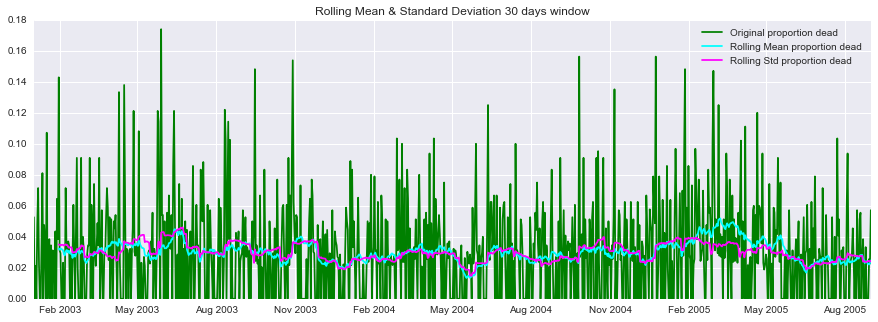

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
test_stationarity(per_day_frame,30)

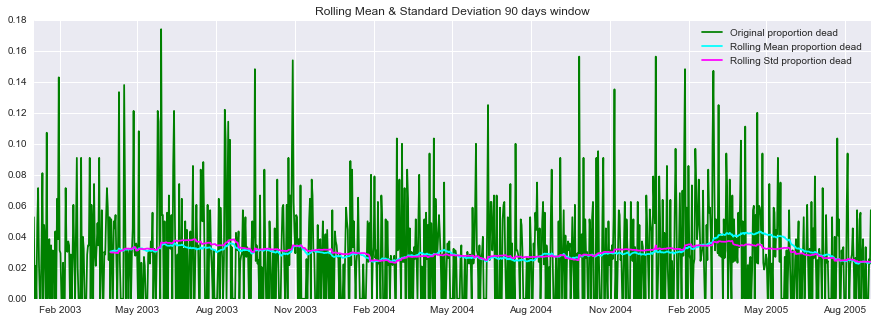

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
test_stationarity(per_day_frame,90)

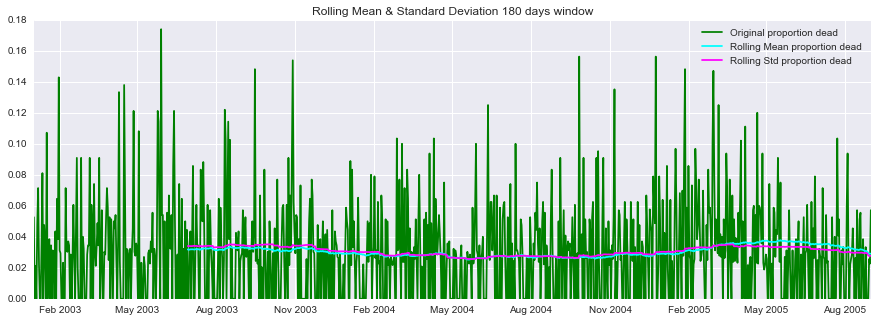

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
test_stationarity(per_day_frame,180)

Based on this visualization, it does not appear like there are meaningful anomalies in proportion dying over time, and anomaly detection on this dataset might be more like meaningless noise detection. Instead, we will build classifiers for our dataset and analyze the importance of the time variables in this classifier building process.

## Data Visualization

Before we start building a classifier, we are interested in some of the underlying characteristics of the patients in our dataset. Data visualization would be an efficient way to examine this.

In [10]:
print 'number of patients: ' , ed_dataset.shape[0]

number of patients:  34812


Generate table of statistics with max, min, range, mean of dataset values, including age, emergency department length of stay, and laboratory test results.

In [11]:
# Table of statistics :
cols = [23, 24, 27, 28, 29, 30, 31, 32, 34, 35, 36]
df_cols = ed_dataset[cols]

# get column names from important columns
column_names = df_cols.columns.values
print column_names

# create pandas df with column names
stats = pd.DataFrame(columns=column_names)

#create a row called 'max', 'min, 'range', 'mean' and store max values 
stats.loc['max'] = df_cols.max() 
stats.loc['min'] = df_cols.min()
stats.loc['range'] = df_cols.max() - df_cols.min()
stats.loc['mean'] = df_cols.mean()

stats.head(n=5)

['Age' 'EDLOS' 'TroponinT' 'Lactate' 'Hemoglobin' 'CRP' 'WBC' 'pH'
 'available_beds' 'ED_occupancy_x' 'IPLOS']


,Age,EDLOS,TroponinT,Lactate,Hemoglobin,CRP,WBC,pH,available_beds,ED_occupancy_x,IPLOS
max,101.900000,24.380000,7199.000000,30.600000,225.000000,815.000000,450.700000,7.730000,172.000000,82.966667,4516.733333
min,15.000000,0.296667,4.000000,0.800000,24.000000,1.200000,-0.100000,6.630000,128.000000,9.433333,-0.133333
range,86.900000,24.083333,7195.000000,29.800000,201.000000,813.800000,450.800000,1.100000,44.000000,73.533333,4516.866666
mean,62.347538,3.796119,19.598788,2.257245,132.297857,32.558894,9.699046,7.387593,154.775365,37.281019,102.795733


Create new dataframes with subsets of original emergency department dataset. Use these new dataframes for visualization via piecharts and histograms. 

In [12]:
women_ed = ed_dataset[ed_dataset['sex'] == 0]
men_ed = ed_dataset[ed_dataset['sex'] == 1]

death_ed = ed_dataset[ed_dataset['hospital_death'] == 1]
nodeath_ed = ed_dataset[ed_dataset['hospital_death'] == 0]

weekend_ed_deaths = ed_dataset[(ed_dataset['weekday'] == 0) &(ed_dataset['hospital_death'] == 1)]
weekend_ed_nodeaths = ed_dataset[(ed_dataset['weekday'] == 0) &(ed_dataset['hospital_death'] == 0)]
weekday_ed_deaths = ed_dataset[(ed_dataset['weekday'] == 1) & (ed_dataset['hospital_death'] == 1)]
weekday_ed_nodeaths = ed_dataset[(ed_dataset['weekday'] == 1) & (ed_dataset['hospital_death'] == 0)]

monday_ed_deaths = ed_dataset[(ed_dataset['day'] == 0) &(ed_dataset['hospital_death'] == 1)]
monday_ed_nodeaths = ed_dataset[(ed_dataset['day'] == 0) &(ed_dataset['hospital_death'] == 0)]
tf_ed_deaths = ed_dataset[(ed_dataset['day'] != 0) & (ed_dataset['hospital_death'] == 1)]
tf_ed_nodeaths = ed_dataset[(ed_dataset['day'] != 0) & (ed_dataset['hospital_death'] == 0)]

ed_1_deaths = ed_dataset[(ed_dataset['first_1_to_4_prio'] == 1) &(ed_dataset['hospital_death'] == 1)]
ed_1_nodeaths = ed_dataset[(ed_dataset['first_1_to_4_prio'] == 1) &(ed_dataset['hospital_death'] == 0)]
ed_2_deaths = ed_dataset[(ed_dataset['first_1_to_4_prio'] == 2) &(ed_dataset['hospital_death'] == 1)]
ed_2_nodeaths = ed_dataset[(ed_dataset['first_1_to_4_prio'] == 2) &(ed_dataset['hospital_death'] == 0)]
ed_3_deaths = ed_dataset[(ed_dataset['first_1_to_4_prio'] == 3) &(ed_dataset['hospital_death'] == 1)]
ed_3_nodeaths = ed_dataset[(ed_dataset['first_1_to_4_prio'] == 3) &(ed_dataset['hospital_death'] == 0)]
ed_4_deaths = ed_dataset[(ed_dataset['first_1_to_4_prio'] == 4) &(ed_dataset['hospital_death'] == 1)]
ed_4_nodeaths = ed_dataset[(ed_dataset['first_1_to_4_prio'] == 4) &(ed_dataset['hospital_death'] == 0)]

Pie charts showing proportion of men and women in ED dataset and hospital deaths and hospital survival. 3% of all patients who were admitted to the hospital from the emergency department died during their hospital stay. Therefore, this dataset is unbalanced.

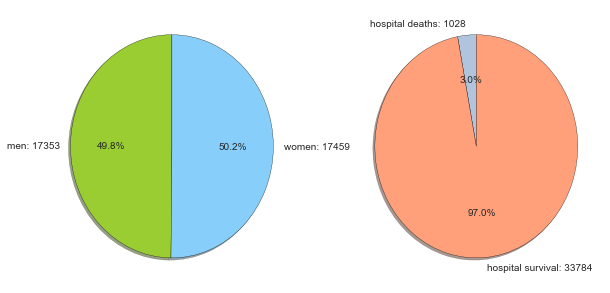

In [13]:
# Pie Charts: 

# Men vs. Women
men = men_ed.shape[0]
women = ed_dataset.shape[0] - men

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121)
ax1.pie([men, women], 
        labels=['men: ' + str(men), 'women: ' + str(women)], 
        colors=['yellowgreen', 'lightskyblue'],
        autopct='%1.1f%%', shadow=True, startangle=90)

# Death vs. No Death 
death = death_ed.shape[0]
no_death = ed_dataset.shape[0] - death

ax2 = fig.add_subplot(122)
ax2.pie([death, no_death], 
        labels=['hospital deaths: ' + str(death), 'hospital survival: ' + str(no_death)], 
        colors=['lightsteelblue', 'lightsalmon'],
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()
#fig.savefig('piesa.png')

The pie charts given below display the proportion of patients who died in the hospital with proportion of patients who did not within subsets of the original dataset. These prorportions are shown for patients who were admitted on a weekday, patients who were admitted on a weekend, patients who were admitted on a Monday, and patients who were admitted on a weekday aside from Monday. Overall, the proportion of hospital deaths remained around 3% for each of these categories of hospital admittance. 

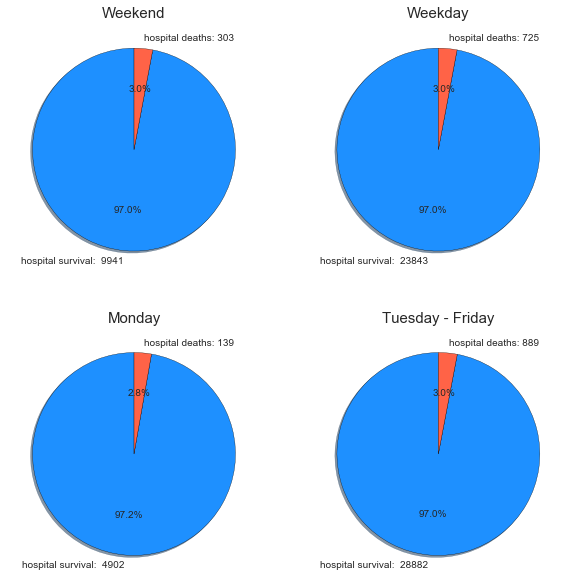

In [14]:
fig = plt.figure(figsize=(10, 10))

# Weekend deaths vs. Weekday deaths 
weekend = weekend_ed_nodeaths.shape[0]
weekend_death = weekend_ed_deaths.shape[0]

ax1 = fig.add_subplot(221)
ax1.pie([weekend, weekend_death], 
        labels=['hospital survival:  ' + str(weekend), 'hospital deaths: ' + str(weekend_death)], 
        colors=['dodgerblue', 'tomato'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Weekend", fontsize = 15)

weekday = weekday_ed_nodeaths.shape[0]
weekday_death = weekday_ed_deaths.shape[0]

ax2 = fig.add_subplot(222)
ax2.pie([weekday, weekday_death], 
        labels=['hospital survival:  ' + str(weekday), 'hospital deaths: ' + str(weekday_death)], 
        colors=['dodgerblue', 'tomato'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Weekday", fontsize = 15)

# Monday vs. Tuesday - Friday
monday = monday_ed_nodeaths.shape[0]
monday_death = monday_ed_deaths.shape[0]

ax3 = fig.add_subplot(223)
ax3.pie([monday, monday_death], 
        labels=['hospital survival:  ' + str(monday), 'hospital deaths: ' + str(monday_death)], 
        colors=['dodgerblue', 'tomato'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Monday", fontsize = 15)

tf = tf_ed_nodeaths.shape[0]
tf_death = tf_ed_deaths.shape[0]

ax4 = fig.add_subplot(224)
ax4.pie([tf, tf_death], 
        labels=['hospital survival:  ' + str(tf), 'hospital deaths: ' + str(tf_death)], 
        colors=['dodgerblue', 'tomato'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Tuesday - Friday", fontsize = 15)

plt.show()
#fig.savefig('piesb.png')

The pie charts given below display the breakdown of severity of disease among patients who survived the hospital visit and paitents who did not. Severity of disease is separated into four categories and this number is given to a patients upon evaluation in the emergency department. One is the most acute and four is the least acute.

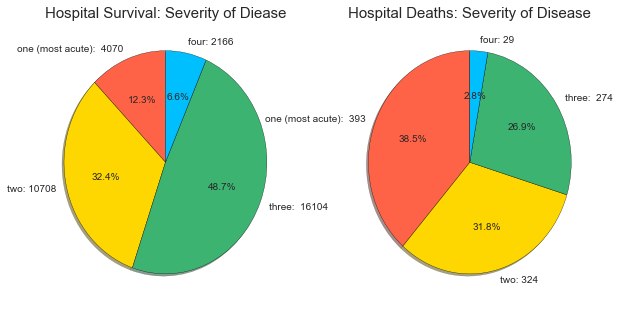

In [15]:
# Pie Charts: 

# Severity of Diease 
one = ed_1_nodeaths.shape[0]
one_death = ed_1_deaths.shape[0]
two = ed_2_nodeaths.shape[0]
two_death = ed_2_deaths.shape[0]
three = ed_3_nodeaths.shape[0]
three_death = ed_3_deaths.shape[0]
four = ed_4_nodeaths.shape[0]
four_death = ed_4_deaths.shape[0]

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121)
ax1.pie([one, two, three, four], 
        labels=['one (most acute):  ' + str(one), 'two: ' + str(two), 'three:  ' + str(three), 'four: ' + str(four)], 
        colors=['tomato', 'gold', 'mediumseagreen', 'deepskyblue'], 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Hospital Survival: Severity of Diease", fontsize = 15)

ax2 = fig.add_subplot(122)
ax2.pie([one_death, two_death, three_death, four_death], 
        labels=['one (most acute):  ' + str(one_death), 'two: ' + str(two_death), 'three:  ' + str(three_death), 'four: ' + str(four_death)], 
        colors=['tomato', 'gold', 'mediumseagreen', 'deepskyblue'], 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.title("Hospital Deaths: Severity of Disease", fontsize = 15)
plt.show()
#fig.savefig('piesc.png')

Histograms were then plotted to visualize the distribution of various characteristics of patients, separated by hospital survival and death. Histograms were then overlayed in order to better visualize and present the data and differences between the distributions.  

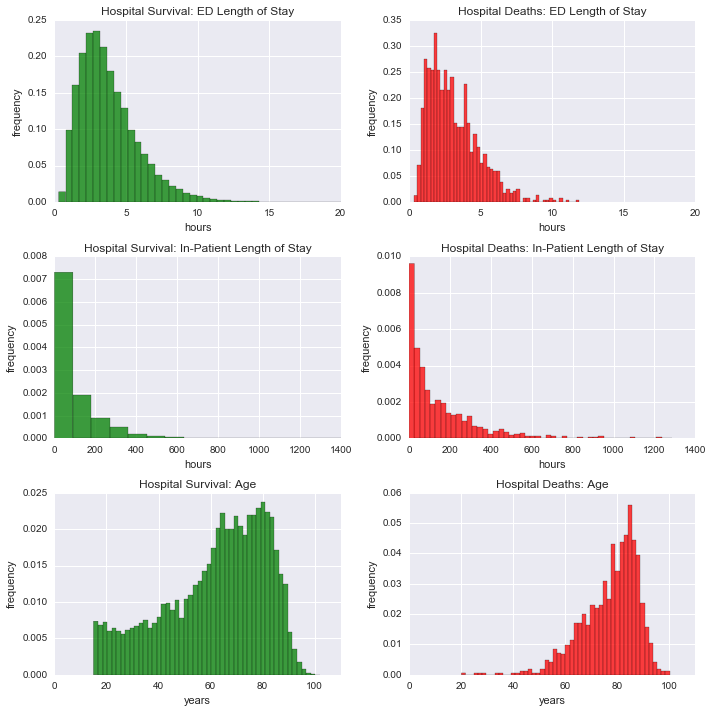

In [16]:
# Adjusted Individual Histograms 

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 10))

ax1.hist(nodeath_ed['EDLOS'].values, bins=50, normed=1,  
        facecolor="green", alpha=0.75)
ax2.hist(death_ed['EDLOS'].values, bins=50, normed=1, 
        facecolor='red', alpha=0.75)
ax1.set_title('Hospital Survival: ED Length of Stay')
ax2.set_title('Hospital Deaths: ED Length of Stay')
ax1.set_xlabel('hours')
ax1.set_ylabel('frequency')
ax1.set_xlim([0, 20])
ax2.set_xlabel('hours')
ax2.set_ylabel('frequency')
ax2.set_xlim([0, 20])


ax3.hist(nodeath_ed['IPLOS'].values, bins=50, normed=1,  
        facecolor="green", alpha=0.75)
ax4.hist(death_ed['IPLOS'].values, bins=50, normed=1, 
        facecolor='red', alpha=0.75)
ax3.set_title('Hospital Survival: In-Patient Length of Stay')
ax3.set_xlabel('hours')
ax3.set_ylabel('frequency')
ax3.set_xlim([0, 1400])
ax4.set_title('Hospital Deaths: In-Patient Length of Stay')
ax4.set_xlabel('hours')
ax4.set_ylabel('frequency')
ax4.set_xlim([0, 1400])


ax5.hist(nodeath_ed['Age'].values, bins=50, normed=1,  
        facecolor="green", alpha=0.75)
ax6.hist(death_ed['Age'].values, bins=50, normed=1, 
        facecolor='red', alpha=0.75)
ax5.set_title('Hospital Survival: Age')
ax5.set_xlabel('years')
ax5.set_ylabel('frequency')
ax5.set_xlim([0, 110])
ax6.set_title('Hospital Deaths: Age')
ax6.set_xlabel('years')
ax6.set_ylabel('frequency')
ax6.set_xlim([0, 110])

plt.tight_layout()
plt.show()
#fig.savefig('histc.png')

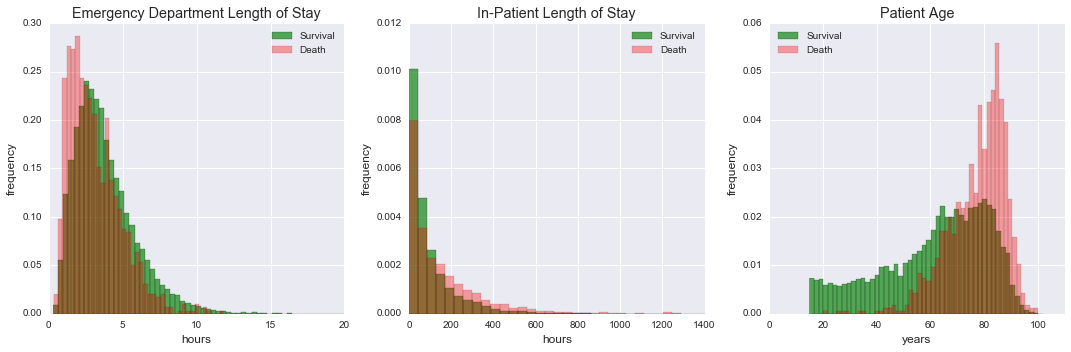

In [17]:
# Overlayed Histograms 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.hist(nodeath_ed['EDLOS'].values, bins=70, normed=1,  
        facecolor="green", alpha=0.65, label='Survival')
ax1.hist(death_ed['EDLOS'].values, bins=40, normed=1, 
        facecolor='red', alpha=0.35, label='Death')
ax1.set_title('Emergency Department Length of Stay', fontsize='x-large')
ax1.set_xlabel('hours', fontsize='large')
ax1.set_ylabel('frequency', fontsize='large')
ax1.set_xlim([0, 20])
ax1.legend(loc='best')

ax2.hist(nodeath_ed['IPLOS'].values, bins=105, normed=1,  
        facecolor="green", alpha=0.65, label='Survival')
ax2.hist(death_ed['IPLOS'].values, bins=30, normed=1, 
        facecolor='red', alpha=0.35, label='Death')
ax2.set_title('In-Patient Length of Stay', fontsize='x-large')
ax2.set_xlabel('hours', fontsize='large')
ax2.set_ylabel('frequency', fontsize='large')
ax2.set_xlim([0, 1400])
ax2.legend(loc='best')

ax3.hist(nodeath_ed['Age'].values, bins=50, normed=1,  
        facecolor="green", alpha=0.65, label='Survival')
ax3.hist(death_ed['Age'].values, bins=50, normed=1, 
        facecolor='red', alpha=0.35, label='Death')
ax3.set_title('Patient Age', fontsize='x-large')
ax3.set_xlabel('years', fontsize='large')
ax3.set_ylabel('frequency', fontsize='large')
ax3.set_xlim([0, 110])
ax3.legend(loc='best')

plt.tight_layout()
plt.show()
#fig.savefig('histb.png')

More histograms were plotted to visualize the distributions of the various laboratory test results among patients who died during their hospital stay and those who did not. 

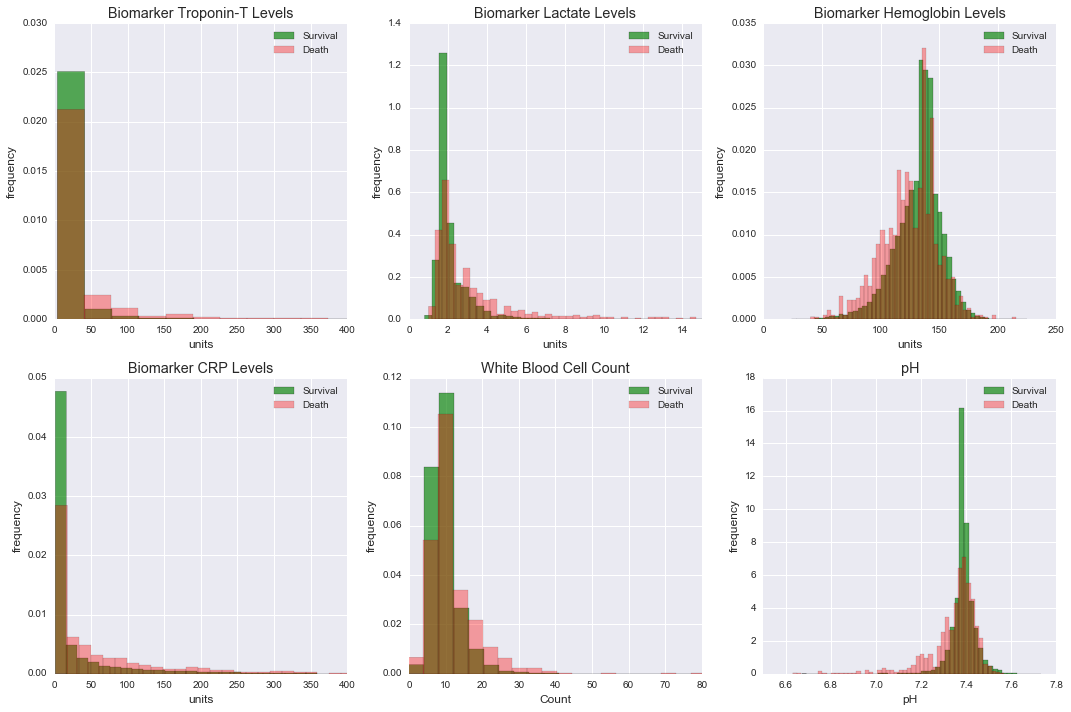

In [18]:
# Histograms of lab values


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize= (15, 10))

# Missing Values -- Remove outliers from lab values 
# Write over this variable for every lab value 

# Troponin-T  :  > 2000 [25 observations] 
dummy_death = ed_dataset[(ed_dataset['TroponinT'] < 2000) & (ed_dataset['hospital_death'] == 1)]
dummy_nodeaths = ed_dataset[(ed_dataset['TroponinT'] < 2000) & (ed_dataset['hospital_death'] == 0)]

ax1.hist(dummy_nodeaths['TroponinT'].values, bins=50, normed=1,  
        facecolor="green", alpha=0.65, label='Survival')
ax1.hist(dummy_death['TroponinT'].values, bins=50, normed=1, 
        facecolor='red', alpha=0.35, label='Death')
ax1.set_title('Biomarker Troponin-T Levels', fontsize='x-large')
ax1.set_xlabel('units', fontsize='large')
ax1.set_ylabel('frequency', fontsize='large')
ax1.set_xlim([0, 400])
ax1.legend(loc='best')


# Lactate : > 20 [13 observations]
dummy_death = ed_dataset[(ed_dataset['Lactate'] < 20) & (ed_dataset['hospital_death'] == 1)]
dummy_nodeaths = ed_dataset[(ed_dataset['Lactate'] < 20) & (ed_dataset['hospital_death'] == 0)]

ax2.hist(dummy_nodeaths['Lactate'].values, bins=50, normed=1,  
        facecolor="green", alpha=0.65, label='Survival')
ax2.hist(dummy_death['Lactate'].values, bins=50, normed=1, 
        facecolor='red', alpha=0.35, label='Death')
ax2.set_title('Biomarker Lactate Levels', fontsize='x-large')
ax2.set_xlabel('units', fontsize='large')
ax2.set_ylabel('frequency', fontsize='large')
ax2.set_xlim([0, 15])
ax2.legend(loc='best')


# Hemoglobin : No change 
ax3.hist(nodeath_ed['Hemoglobin'].values, bins=50, normed=1,  
        facecolor="green", alpha=0.65, label='Survival')
ax3.hist(death_ed['Hemoglobin'].values, bins=50, normed=1, 
        facecolor='red', alpha=0.35, label='Death')
ax3.set_title('Biomarker Hemoglobin Levels', fontsize='x-large')
ax3.set_xlabel('units', fontsize='large')
ax3.set_ylabel('frequency', fontsize='large')
#ax3.set_xlim([0, 110])
ax3.legend(loc='best')


# CRP
dummy_death = ed_dataset[(ed_dataset['CRP'] < 9000) & (ed_dataset['hospital_death'] == 1)]
dummy_nodeaths = ed_dataset[(ed_dataset['CRP'] < 9000) & (ed_dataset['hospital_death'] == 0)]

ax4.hist(dummy_nodeaths['CRP'].values, bins=50, normed=1,  
        facecolor="green", alpha=0.65, label='Survival')
ax4.hist(dummy_death['CRP'].values, bins=50, normed=1, 
        facecolor='red', alpha=0.35, label='Death')
ax4.set_title('Biomarker CRP Levels', fontsize='x-large')
ax4.set_xlabel('units', fontsize='large')
ax4.set_ylabel('frequency', fontsize='large')
ax4.set_xlim([0, 400])
ax4.legend(loc='best')


# WBC
dummy_death = ed_dataset[(ed_dataset['WBC'] < 9000) & (ed_dataset['hospital_death'] == 1)]
dummy_nodeaths = ed_dataset[(ed_dataset['WBC'] < 9000) & (ed_dataset['hospital_death'] == 0)]

ax5.hist(dummy_nodeaths['WBC'].values, bins=110, normed=1,  
        facecolor="green", alpha=0.65, label='Survival')
ax5.hist(dummy_death['WBC'].values, bins=50, normed=1, 
        facecolor='red', alpha=0.35, label='Death')
ax5.set_title('White Blood Cell Count', fontsize='x-large')
ax5.set_xlabel('Count', fontsize='large')
ax5.set_ylabel('frequency', fontsize='large')
ax5.set_xlim([0, 80])
ax5.legend(loc='best')


# pH
dummy_death = ed_dataset[(ed_dataset['pH'] < 9) & (ed_dataset['hospital_death'] == 1)]
dummy_nodeaths = ed_dataset[(ed_dataset['pH'] < 9) & (ed_dataset['hospital_death'] == 0)]

ax6.hist(dummy_nodeaths['pH'].values, bins=50, normed=1,  
        facecolor="green", alpha=0.65, label='Survival')
ax6.hist(dummy_death['pH'].values, bins=50, normed=1, 
        facecolor='red', alpha=0.35, label='Death')
ax6.set_title('pH', fontsize='x-large')
ax6.set_xlabel('pH', fontsize='large')
ax6.set_ylabel('frequency', fontsize='large')
ax6.set_xlim([6.5, 7.8])
ax6.legend(loc='best')

plt.tight_layout()
plt.show()
#fig.savefig('histd.png')

## Missing Values 

In a clinical setting, laboratory values are entered into the electronic health record (EHR) system manually by laboratory staff. If there is an error in the analysis process, the laboratory staff enters an error message into the system. Such values were replaced with NaN in this dataset for study purposes. Some patients also lacked entries for laboratory values altogether. This is relatively common, as not all patients have all lab values analyzed (i.e. there must be a rationale or an indication for drawing a certain laboratory test). Hence, cases who had no entry for a particular laboratory test in the EHR database were considered  not having needed the particular laboratory test and where therefore assumed to have a low probability of the disease that a particular lab test could be used to show. Therefore, such missing cases had a random value in the normal range of the lab parameter imputed. Both these types of missing values accounted for were encountered for all of the six variables describing laboratory results:


No lab value registered:
Troponin T (29059/40000)
Lactate (12679/40000)
CRP (13160/40000)
White Blood Cells (13206/40000)
Hemoglobin (7836/40000)
pH (9565/40000)


Error registered:
Troponin T (167/40000)
Lactate (25/40000)
CRP (18/40000)
White Blood Cells (46/40000)
Hemoglobin (67/40000)
pH (33/40000)


In the case of disease severity (expressed by the triage-algorithm) missing values were indicated as a separate category. No missing values where encountered for the other variables included in the study. No serviceinterruptions were reported for the EHR system during the study period. 


first_1_to_4_prio (780/40000)


In [19]:
#READING IN THE DATASET
ed_data = pd.read_csv("ED_with_time_indicators_2nd.csv", delimiter=',')

In [20]:
#changing data-type of time variable to datetime
ed_data.ADMISSION_DATE = pd.to_datetime(ed_data['ADMISSION_DATE'])
ed_data = ed_data.drop("admission_datetime",axis=1) #dropping unnecessary variable
for var in ed_data.columns.values: #changing dtype of other variables to float
    if var == "ADMISSION_DATE":
        pass
    else:
        ed_data[var] = ed_data[var].astype(float)

In [21]:
#Investigating missing values
for var in ed_data.columns.values:
    print "#####", var, "-----number missing", ed_data[var].isnull().sum()

##### Unnamed: 0 -----number missing 0
##### ADMISSION_DATE -----number missing 0
##### day -----number missing 0
##### weekday -----number missing 0
##### month -----number missing 0
##### year -----number missing 0
##### Jan -----number missing 0
##### Feb -----number missing 0
##### Mar -----number missing 0
##### Apr -----number missing 0
##### May -----number missing 0
##### Jun -----number missing 0
##### Jul -----number missing 0
##### Aug -----number missing 0
##### Sep -----number missing 0
##### Oct -----number missing 0
##### Nov -----number missing 0
##### Dec -----number missing 0
##### X2003 -----number missing 0
##### X2004 -----number missing 0
##### X2005 -----number missing 0
##### sex -----number missing 0
##### Age -----number missing 0
##### EDLOS -----number missing 0
##### first_1_to_4_prio -----number missing 0
##### nbr_ward_instances -----number missing 0
##### TroponinT -----number missing 0
##### Lactate -----number missing 0
##### Hemoglobin -----number mis

In [22]:
###PREPARING TO CREATE CORRELATION MATRIX####
ed_data_outcomes = ed_data.iloc[:,-1:].values.ravel()
ed_data_features = ed_data.drop(["hospital_death"],axis=1)
ed_data_features_wo_timevar = ed_data_features.drop(["ADMISSION_DATE"],axis=1)
x = np.asarray(ed_data_features)
x2_ = np.asarray(ed_data_features_wo_timevar)
y = ed_data_outcomes
print x.shape, x2_.shape, y.shape

(34812, 36) (34812, 35) (34812,)


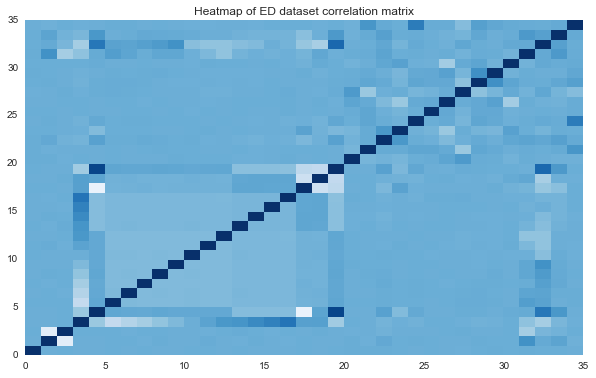

In [23]:
corr_matrix = np.corrcoef(x2_.T)

corrmin, corrmax = -np.abs(corr_matrix).max(), np.abs(corr_matrix).max()

fig, ax = plt.subplots(1, 1)
ax.pcolor(corr_matrix, cmap=matplotlib.cm.Blues, vmin=corrmin, vmax=corrmax)
ax.set_title('Heatmap of ED dataset correlation matrix')
ax.set_xlim((0,35))
ax.set_ylim((0,35))
plt.show()

This concludes our preliminary data exploration and visualization.

# <font color = 'blue'> <center> Part III. Model Building </center> </font>

# <font color = 'blue'> Part IIIA. Building a Classifier To Predict Hospital Death, Excluding Time Variables </font>

Now, we are interested in building a classifier to predict an unfortunate outcome (hospital death). We first try to exclude any time variables, assuming that the time of admission into the hospital is not a good predictive factor for hospital death. We can then compare performance against a classifier built including the time variables in the training set to see if there is a dramatic difference in performance. 

In [28]:
total_data = pd.read_csv('ED_EDUCATIONAL.csv')

For this project, we will only consider those in the dataset who are adults.
This is because children and adults can differ in biomarker levels, and children are likely to be treated with extra caution upon presentation to the emergency room (and thus become hospitalized).
The age has been perturbed, i.e. a fixed number has been subtracted from the true age. This fixed number is ~3 (as per Mathias), so the adults are people with age >= 15. This will remove 4,212 observations from our dataset.

In [29]:
# How many in this dataset are children? We want to work on subset of dataframe that is adults.
np.sum(total_data['Age'] < 15)

4212

Subset the data to only include adults.

In [30]:
adults_data = total_data.loc[total_data['Age'] >= 15]
adults_data.head()

,Unnamed: 0,ADMISSION_DATE,sex,Age,EDLOS,first_1_to_4_prio,nbr_ward_instances,TroponinT,Lactate,Hemoglobin,CRP,WBC,pH,occupancy,available_beds,ED_occupancy_x,IPLOS,hospital_death
0,0,2003-05-01 15:26:00,1.0,30.0,3.066667,3.0,1.0,5.0,1.9,136.0,6.0,8.3,7.39,0.977949,154.0,40.900000,20.350000,0.0
1,1,2004-02-06 11:56:00,1.0,28.8,1.216667,1.0,1.0,5.0,3.3,151.0,3.1,15.1,7.33,0.945065,152.0,51.016667,48.350000,0.0
2,2,2005-02-05 12:46:00,1.0,73.7,2.600000,3.0,1.0,66.0,3.3,78.0,33.0,8.9,7.35,1.065901,159.0,56.233333,21.350000,0.0
3,3,2004-11-16 16:03:00,0.0,45.4,2.713333,2.0,1.0,4.0,5.8,183.0,5.0,7.8,7.38,0.946250,161.0,33.400000,20.750000,0.0
4,4,2003-07-27 22:45:00,0.0,87.3,3.550000,3.0,1.0,5.0,1.6,109.0,5.8,13.5,7.35,0.938571,152.0,40.016667,273.016667,0.0


In [31]:
print adults_data.shape

(35788, 18)


This leaves us with 35,788 observations to work with.

Convert admission date to datetime object.

In [32]:
# convert to datetime object
adults_data['ADMISSION_DATE'] = pd.to_datetime(adults_data['ADMISSION_DATE'])

/Users/isabelle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [33]:
type(adults_data['ADMISSION_DATE'][0])

pandas.tslib.Timestamp

In [34]:
adults_data.drop(adults_data.columns[[0]], axis=1, inplace=True)

/Users/isabelle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In our final step of data cleaning, we exclude points that have lab test values of 9000 or greater. These high values were entered because some error in the testing process prevented accurate results from being obtained (i.e. coagulation in the test tube, etc).
We see from the description of our data file above that there are four variables with maximum values exceeding 9000. They are TroponinT, CRP, WBC, and pH. Thus, we will subset the adults to look at only the adults with values < 9000 for these lab tests.

In [35]:
adults_data = adults_data[adults_data["TroponinT"] < 9000]
adults_data = adults_data[adults_data["CRP"] < 9000]
adults_data = adults_data[adults_data["WBC"] < 9000]
adults_data = adults_data[adults_data["pH"] < 9000]

In [36]:
adults_data.describe()

,sex,Age,EDLOS,first_1_to_4_prio,nbr_ward_instances,TroponinT,Lactate,Hemoglobin,CRP,WBC,pH,occupancy,available_beds,ED_occupancy_x,IPLOS,hospital_death
count,34812.000000,34812.000000,34812.000000,34812.000000,34812.000000,34812.000000,34812.000000,34812.000000,34812.000000,34812.000000,34812.000000,34812.000000,34812.000000,34812.000000,34812.000000,34812.000000
mean,0.498478,62.347538,3.796119,2.532489,1.142279,19.598788,2.257245,132.297857,32.558894,9.699046,7.387593,0.973741,154.775365,37.281019,102.795733,0.029530
std,0.500005,19.751668,2.090158,0.871613,0.434246,114.388333,1.270789,20.002181,63.749008,5.998242,0.057840,0.055007,4.476192,12.619028,142.277686,0.169289
min,0.000000,15.000000,0.296667,1.000000,1.000000,4.000000,0.800000,24.000000,1.200000,-0.100000,6.630000,0.749740,128.000000,9.433333,-0.133333,0.000000
25%,0.000000,49.800000,2.296667,2.000000,1.000000,5.000000,1.700000,122.000000,5.000000,7.800000,7.370000,0.943571,152.000000,28.150000,21.400000,0.000000
50%,0.000000,66.300000,3.380000,3.000000,1.000000,6.000000,1.900000,136.000000,7.000000,8.300000,7.390000,0.978415,153.000000,37.283333,51.850000,0.000000
75%,1.000000,78.100000,4.863333,3.000000,1.000000,8.000000,2.300000,143.000000,25.000000,10.800000,7.410000,1.009737,156.000000,45.883333,129.900000,0.000000
max,1.000000,101.900000,24.380000,5.000000,12.000000,7199.000000,30.600000,225.000000,815.000000,450.700000,7.730000,1.131883,172.000000,82.966667,4516.733333,1.000000


This leaves us with 34,812 adults to start our analysis/ classifier building.

In [37]:
adults_data.head()

,ADMISSION_DATE,sex,Age,EDLOS,first_1_to_4_prio,nbr_ward_instances,TroponinT,Lactate,Hemoglobin,CRP,WBC,pH,occupancy,available_beds,ED_occupancy_x,IPLOS,hospital_death
0,2003-05-01 15:26:00,1.0,30.0,3.066667,3.0,1.0,5.0,1.9,136.0,6.0,8.3,7.39,0.977949,154.0,40.900000,20.350000,0.0
1,2004-02-06 11:56:00,1.0,28.8,1.216667,1.0,1.0,5.0,3.3,151.0,3.1,15.1,7.33,0.945065,152.0,51.016667,48.350000,0.0
2,2005-02-05 12:46:00,1.0,73.7,2.600000,3.0,1.0,66.0,3.3,78.0,33.0,8.9,7.35,1.065901,159.0,56.233333,21.350000,0.0
3,2004-11-16 16:03:00,0.0,45.4,2.713333,2.0,1.0,4.0,5.8,183.0,5.0,7.8,7.38,0.946250,161.0,33.400000,20.750000,0.0
4,2003-07-27 22:45:00,0.0,87.3,3.550000,3.0,1.0,5.0,1.6,109.0,5.8,13.5,7.35,0.938571,152.0,40.016667,273.016667,0.0


## Classifier building
We split our cleaned data into predictors and response (hospital death). Printing out corresponding shapes allows us to double check that we split the dataframe correctly. We then split the data into training and test sets, using 65% of our data for training and 35% of our data for testing.

In [38]:
## Split into train, test
# predictors = adults_data.iloc[:, 1:-4].values
predictors = adults_data.values[:, 1:-1]

print predictors.shape #Check correct shape
print predictors[0][0], predictors[0][-1] #Check we got the correct columns 

# response = adults_data.iloc[:, -4]
response = adults_data.values[:, -1]
print response.shape # Check this is the correct column 
print response[:10] # Check this is the correct column 

(34812, 15)
1.0 20.35
(34812,)
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


In [39]:
x_train, x_test, y_train, y_test = train_test_split(predictors, response, train_size = .65)
print 'Predictors:', x_train.shape, x_test.shape
print 'Response:', y_train.shape, y_test.shape

# Compare proportions of hospital death in training and test
# Small, but should be equal
print 'Proportion of hospital deaths in training set:', np.sum(y_train)/ len(y_train)
print 'Proportion of hospital deaths in test set:', np.sum(y_test)/ len(y_test)

Predictors: (22627, 15) (12185, 15)
Response: (22627,) (12185,)
Proportion of hospital deaths in training set: 0.0292128872586
Proportion of hospital deaths in test set: 0.030118998769


The outcome we are trying to build a classifier for, hospital deaths, happens in only approximately 3% of our dataset. We have quite an unbalanced dataset, and we suspect that this will create certain problems in the model building process.

In [40]:
# classifiers need integer labels
y_train = y_train.astype(int)
y_test = y_test.astype(int)

### Start implementing classifiers
I start with some baseline models: unweighted logistic, weighted logistic, lda, qda, decision trees, random forest. I decided not to include knn or SVM because of computing time.
With each model, print out a classification report that gives precision and recall(accuracy) on each class. 

In [41]:
class_labels = ['No Hospital Death', 'Hospital Death']
unweighted_logistic = LogisticRegression()
unweighted_logistic.fit(x_train, y_train)
unweighted_log_y_pred = unweighted_logistic.predict(x_test)
print('Unweighted Logistic')
print(classification_report(y_test, unweighted_log_y_pred, target_names = class_labels))
print('\n')


weighted_logistic = LogisticRegression(class_weight='balanced')
weighted_logistic.fit(x_train, y_train)
weighted_log_y_pred = weighted_logistic.predict(x_test)
print('Weighted Logistic')
print(classification_report(y_test, weighted_log_y_pred, target_names = class_labels))
print('\n')

lda = LDA()
lda.fit(x_train, y_train)
lda_y_pred = lda.predict(x_test)
print('LDA')
print(classification_report(y_test, lda_y_pred, target_names = class_labels))
print('\n')

qda = QDA()
qda.fit(x_train, y_train)
qda_y_pred = qda.predict(x_test)
print('QDA')
print(classification_report(y_test, qda_y_pred, target_names = class_labels))
print('\n')

tree = DecisionTree(max_depth=6)
tree.fit(x_train, y_train)
tree_y_pred = tree.predict(x_test)
print('Decision Tree')
print(classification_report(y_test, tree_y_pred, target_names = class_labels))
print('\n')

rf = RandomForest()
rf.fit(x_train, y_train)
rf_y_pred = rf.predict(x_test)
print('Random Forest')
print(classification_report(y_test, rf_y_pred, target_names = class_labels))
print('\n')

Unweighted Logistic
                   precision    recall  f1-score   support

No Hospital Death       0.97      1.00      0.98     11818
   Hospital Death       0.50      0.03      0.06       367

      avg / total       0.96      0.97      0.96     12185



Weighted Logistic
                   precision    recall  f1-score   support

No Hospital Death       0.99      0.76      0.86     11818
   Hospital Death       0.09      0.79      0.16       367

      avg / total       0.96      0.76      0.84     12185



LDA
                   precision    recall  f1-score   support

No Hospital Death       0.97      0.99      0.98     11818
   Hospital Death       0.27      0.14      0.18       367

      avg / total       0.95      0.96      0.96     12185



QDA
                   precision    recall  f1-score   support

No Hospital Death       0.98      0.96      0.97     11818
   Hospital Death       0.19      0.31      0.23       367

      avg / total       0.95      0.94      0.95    

Based on the results from these baseline models, I decide to explore weighted logistic regression and decision trees/random forest. The baseline weighted logistic regression model yielded the highest accuracy with hospital death, so I have a hunch that this will be the most useful model.

However, while decision trees and random forests yielded very low accuracy with hospital death, the decision tree structure might represent how a clinician carries out decisions. 
I am interested in what the decision tree uses as important variables, so I will first quickly explore that. Since I'm working with the trees, I might as well try to tune them to see if they can perform any better on class 1.

Then, I will move on to working on improving the weighted logistic regression model. 

#### Exploring Decision Trees/ Random Forest

In [42]:
# Explore the simple decision tree model
def display_dt(model):
    dummy_io = StringIO.StringIO()
    export_graphviz(model, out_file = dummy_io)
    print dummy_io.getvalue()

In [43]:
simple_tree = DecisionTree(max_depth=6)
simple_tree.fit(x_train, y_train)
display_dt(simple_tree)

digraph Tree {
node [shape=box] ;
0 [label="X[10] <= 7.255\ngini = 0.0567\nsamples = 22627\nvalue = [21966, 661]"] ;
1 [label="X[14] <= 8.8083\ngini = 0.33\nsamples = 499\nvalue = [395, 104]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="X[1] <= 77.2\ngini = 0.4444\nsamples = 54\nvalue = [18, 36]"] ;
1 -> 2 ;
3 [label="X[10] <= 7.125\ngini = 0.4953\nsamples = 31\nvalue = [17, 14]"] ;
2 -> 3 ;
4 [label="X[7] <= 149.0\ngini = 0.32\nsamples = 10\nvalue = [2, 8]"] ;
3 -> 4 ;
5 [label="gini = 0.0\nsamples = 7\nvalue = [0, 7]"] ;
4 -> 5 ;
6 [label="X[11] <= 0.9315\ngini = 0.4444\nsamples = 3\nvalue = [2, 1]"] ;
4 -> 6 ;
7 [label="gini = 0.0\nsamples = 1\nvalue = [0, 1]"] ;
6 -> 7 ;
8 [label="gini = 0.0\nsamples = 2\nvalue = [2, 0]"] ;
6 -> 8 ;
9 [label="X[13] <= 55.8917\ngini = 0.4082\nsamples = 21\nvalue = [15, 6]"] ;
3 -> 9 ;
10 [label="X[1] <= 61.0\ngini = 0.3324\nsamples = 19\nvalue = [15, 4]"] ;
9 -> 10 ;
11 [label="gini = 0.0\nsamples = 9\nvalue = [9, 0]"] 

The first node in the decision tree above is blood pH: threshold value <= 7.255
Medically, blood PH level of 7.2 requires dire action.
If blood pH is <= 7.255, then the next node is IPLOS, or inpatient length of stay.
If blood pH > 7.255, then the next node is age.

Might as well try to tune the trees to see if accuracy on class 1 improves! 
First, we try tuning the depth of the tree. We also try an adaptive-boosting method, in which the results from many trees are combined in the final output. 

In [44]:
# try different depths, get precision / accuracy
depths = range(2,10)
for depth in depths:
    # fit simple tree 
    print("Tree")
    dt = DecisionTree(max_depth = depth)
    dt.fit(x_train, y_train)
    print depth
    print classification_report(y_test, dt.predict(x_test), target_names = class_labels)
    print '\n'
    print("Adaboosted tree")
    # fit adaboosted tree
    bdt = AdaBoostClassifier(DecisionTree(max_depth = depth))
    bdt.fit(x_train, y_train)
    print classification_report(y_test, bdt.predict(x_test), target_names = class_labels)
    

Tree
2
                   precision    recall  f1-score   support

No Hospital Death       0.97      1.00      0.99     11818
   Hospital Death       0.66      0.05      0.10       367

      avg / total       0.96      0.97      0.96     12185



Adaboosted tree
                   precision    recall  f1-score   support

No Hospital Death       0.97      1.00      0.98     11818
   Hospital Death       0.46      0.13      0.20       367

      avg / total       0.96      0.97      0.96     12185

Tree
3
                   precision    recall  f1-score   support

No Hospital Death       0.97      1.00      0.99     11818
   Hospital Death       0.85      0.03      0.06       367

      avg / total       0.97      0.97      0.96     12185



Adaboosted tree
                   precision    recall  f1-score   support

No Hospital Death       0.97      0.99      0.98     11818
   Hospital Death       0.35      0.15      0.21       367

      avg / total       0.96      0.97      0.96     1

I'm not impressed by the performance of the decision tree on accurately classifying class 1, even after trying out various depths and implementing adaptive boosting. Maybe a random forest, a cohort of decision trees, will give us a better classifier.

I will implement some random forests and tune them.

In [45]:
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])],
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

# try to tune random forests- what is optimal number of trees?
ntrees = range(1, 20)
kf = KFold(len(x_train), n_folds=5)

class1_accuracies = []

for tree in ntrees:
    print 'Trees:', tree
    
    accuracies = []
    
    for train_index, test_index in kf:
        x_validate_train, x_validate_test = x_train[train_index], x_train[test_index]
        y_validate_train, y_validate_test = y_train[train_index], y_train[test_index]
        
        rf = RandomForest(n_estimators = tree, max_depth = 8) # Pick best depth from above tuning for depth.
        rf.fit(x_validate_train, y_validate_train)
        
        y_pred = rf.predict(x_validate_test)
        scores = score(rf, x_validate_test, y_validate_test)
        accuracies.append(scores['accuracy on class 1'])
        
    class1_accuracies.append(np.mean(accuracies))

print class1_accuracies 
best_tree = np.argmax(class1_accuracies) +1
print 'Best forest has this many trees:', best_tree

Trees: 1
Trees: 2
Trees: 3
Trees: 4
Trees: 5
Trees: 6
Trees: 7
Trees: 8
Trees: 9
Trees: 10
Trees: 11
Trees: 12
Trees: 13
Trees: 14
Trees: 15
Trees: 16
Trees: 17
Trees: 18
Trees: 19
[0.10228726195514178, 0.079935421074904783, 0.038029538721963609, 0.051233093525179851, 0.051042657638595001, 0.034636648328396108, 0.031500126957257721, 0.036107236563690227, 0.028495471857807868, 0.031534320778671181, 0.030029538721963605, 0.033263732543377063, 0.025940076174354631, 0.034538975878121034, 0.028817774016081255, 0.031629538721963606, 0.028397799407532797, 0.03322953872196361, 0.028495471857807868]
Best forest has this many trees: 1


The random forest that gives the best accuracy on class 1 has two trees, and even then, it gives a 7.7% accuracy on classifying class 1. Given these disappointing results, it's time to move on to tuning the weighted logistic regression classifier.

### Explore: Weighted logistic regression
First, I try a weighted logistic regression with cross-validation to tune for best C, or regularization parameter. The regularization parameter will help avoid overfitting. Smaller values specify stronger regularization. 

In [46]:
logistic = LogisticRegressionCV(Cs = 10, class_weight='balanced')
logistic.fit(x_train, y_train)
score(logistic, x_test, y_test)

overall accuracy       0.756176
accuracy on class 0    0.754781
accuracy on class 1    0.801090
dtype: float64

Off the bat, this is not a bad place to start- we have 78.6% accuracy on class 1!
We wil try some more Cs.

In [47]:
logistic = LogisticRegressionCV(Cs = [1, 10, 100, 1000], class_weight='balanced')
logistic.fit(x_train, y_train)
print score(logistic, x_test, y_test)
print classification_report(y_test, logistic.predict(x_test))

conf_mat = confusion_matrix(y_test, logistic.predict(x_test))
# Create dataframe from confusion matrix
conf_df = pd.DataFrame(conf_mat, columns=['y_hat=0', 'y_hat=1'], index=['y=0', 'y=1'])
print conf_df

overall accuracy       0.755355
accuracy on class 0    0.754442
accuracy on class 1    0.784741
dtype: float64
             precision    recall  f1-score   support

          0       0.99      0.75      0.86     11818
          1       0.09      0.78      0.16       367

avg / total       0.96      0.76      0.84     12185

     y_hat=0  y_hat=1
y=0     8916     2902
y=1       79      288


I try an adaboosted implementation to see if this improves our cross-validated logistic regression model. 

In [48]:
logistic_boost = AdaBoostClassifier(LogisticRegressionCV(Cs = [1, 10, 100, 1000], class_weight='balanced'))
logistic_boost.fit(x_train, y_train)
score(logistic_boost, x_test, y_test)

overall accuracy       0.756914
accuracy on class 0    0.755965
accuracy on class 1    0.787466
dtype: float64

The best way to improve our weighted logistic regression classifier for such a rare outcome is to change the threshold probability at which the classifier predicts hospital death. By default, if the predicted probability of an individual is > 0.5, then the classifier will classify that individual as a hospital death. However, we might be able to capture more true hospital deaths by lowering this threshold.

In [49]:
#--------  thresholded_accuracy
# From CS109 Challenge homework 
# A function to evaluate accuracy of LogReg model with threshold 't'
# Input: 
#      model (LogReg model)
#      t (threshold)
#      x (n x d array of predictors)
#      y (n x 1 array of binary response variable vals)
def thresholded_accuracy(model, t, x, y):
    # Get the class probabilities rather than class predictions from log reg
    y_prob = model.predict_proba(x)[:, 1]
    # Make the class predictions based on threshold
    y_pred = np.zeros((x.shape[0], 1)).reshape(-1, )
    # If P(y=1|x) > threshold t then we set the label to 1: y = 1
    y_pred[y_prob > t] = 1
    # Compute accuracy of our predictions
    accuracy = np.mean(y_pred == y)
    return accuracy

In [50]:
logistic = LogisticRegressionCV(Cs = [1, 10, 100, 1000], class_weight='balanced')
logistic.fit(x_train, y_train)

thresholds = [0.05, 0.10, 0.15, 0.2, 0.25, 0.30, 0.35, 0.40, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.55]
for threshold in thresholds:
    print '\n'
    print threshold
    print 'Train set:\n\t total accuracy:', thresholded_accuracy(logistic, threshold, x_train, y_train),\
            '\n\t accuracy on class 0:', thresholded_accuracy(logistic, threshold, x_train[y_train==0, :], \
                                                              y_train[y_train==0]),\
            '\n\t accuracy on class 1:', thresholded_accuracy(logistic, threshold, x_train[y_train==1, :], \
                                                              y_train[y_train==1])
    print 'Test set:\n\t total accuracy:', thresholded_accuracy(logistic, threshold, x_test, y_test),\
            '\n\t accuracy on class 0:', thresholded_accuracy(logistic, threshold, x_test[y_test==0, :], \
                                                            y_test[y_test==0]) ,\
            '\n\t accuracy on class 1:', thresholded_accuracy(logistic, threshold, x_test[y_test==1, :], \
                                                             y_test[y_test==1]),\
            



0.05
Train set:
	 total accuracy: 0.196269942988 
	 accuracy on class 0: 0.172084130019 
	 accuracy on class 1: 1.0
Test set:
	 total accuracy: 0.196306934756 
	 accuracy on class 0: 0.171348789981 
	 accuracy on class 1: 1.0 

0.1
Train set:
	 total accuracy: 0.297078711274 
	 accuracy on class 0: 0.276245106073 
	 accuracy on class 1: 0.989409984871
Test set:
	 total accuracy: 0.292819039803 
	 accuracy on class 0: 0.2708580132 
	 accuracy on class 1: 1.0 

0.15
Train set:
	 total accuracy: 0.376276130287 
	 accuracy on class 0: 0.358007830283 
	 accuracy on class 1: 0.983358547655
Test set:
	 total accuracy: 0.376282314321 
	 accuracy on class 0: 0.357082416653 
	 accuracy on class 1: 0.994550408719 

0.2
Train set:
	 total accuracy: 0.45003756574 
	 accuracy on class 0: 0.434307566239 
	 accuracy on class 1: 0.972768532526
Test set:
	 total accuracy: 0.443085761182 
	 accuracy on class 0: 0.426129632764 
	 accuracy on class 1: 0.989100817439 

0.25
Train set:
	 total accuracy: 0.

We can see the tradeoffs of different thresholds. An extremely low threshold will basically classify most points as hospital deaths, thus, it is likely that we will correctly classify all true hospital deaths, but we will also increase our number of false positives. Additionally, the ability to predict hospital survival accurately decreases.

The threshold p = 0.45 seems to hit a good sweet spot of overall accuracy and high accuracy on class 1 (hospital death). 

After this exploration of model building, I decide to stick with a cross-validated, weighted logistic regression model with a custom threshold of p = 0.45. Now it's time to run this classifier on the entire dataset and save the outputs.

### Save dataframe with predictions as put out by best classifier.

Implement classifier on test data, return predicted class label and predicted probability.

In [51]:
def predict_best_classifier(x_test):
    # give spredicted values
    # best classifier as defined in function below 
    
    # weighted logreg, cross-validated with different threshold.
    threshold = .45
    y_prob = logistic.predict_proba(x_test)[:, 1]
    
    # make clas predicions based on chosen threshold
    y_pred = np.zeros((x_test.shape[0],1)).reshape(-1,)
    # If P(y=1|x) > threshold t, we set label y = 1
    y_pred[y_prob > threshold] = 1
    return y_pred, y_prob

Test this function out on the test set. We print out the total number of points labeled as hospital death from the classifier's prediction, and the true total number of points labeled as hospital death.

In [52]:
y_pred, y_prob = predict_best_classifier(x_test)
print sum(y_pred)
print sum(y_test)

3734.0
367


Our classifier gives us 3,673 hospital deaths in the test set while there are actually only 374. We are overestimating hospital death, but in this case, it would be better to have more false positives of hospital death instead of have many false negatives, which could lead to patient negligence (better safe than sorry!) 

In [53]:
death_pred, death_prob = predict_best_classifier(predictors)
print len(death_pred)

34812


I ran our entire working data through the classifier, and made sure we got the appropriate length of output (34,812 patients). 
I now append the predicted probability and the predicted label to the dataframe, and export this dataframe to a csv file.

In [54]:
adults_data['class prediction'] = death_pred
adults_data['class prob'] = death_prob
adults_data.head()

,ADMISSION_DATE,sex,Age,EDLOS,first_1_to_4_prio,nbr_ward_instances,TroponinT,Lactate,Hemoglobin,CRP,WBC,pH,occupancy,available_beds,ED_occupancy_x,IPLOS,hospital_death,class prediction,class prob
0,2003-05-01 15:26:00,1.0,30.0,3.066667,3.0,1.0,5.0,1.9,136.0,6.0,8.3,7.39,0.977949,154.0,40.900000,20.350000,0.0,0.0,0.021530
1,2004-02-06 11:56:00,1.0,28.8,1.216667,1.0,1.0,5.0,3.3,151.0,3.1,15.1,7.33,0.945065,152.0,51.016667,48.350000,0.0,0.0,0.104478
2,2005-02-05 12:46:00,1.0,73.7,2.600000,3.0,1.0,66.0,3.3,78.0,33.0,8.9,7.35,1.065901,159.0,56.233333,21.350000,0.0,1.0,0.597941
3,2004-11-16 16:03:00,0.0,45.4,2.713333,2.0,1.0,4.0,5.8,183.0,5.0,7.8,7.38,0.946250,161.0,33.400000,20.750000,0.0,0.0,0.155325
4,2003-07-27 22:45:00,0.0,87.3,3.550000,3.0,1.0,5.0,1.6,109.0,5.8,13.5,7.35,0.938571,152.0,40.016667,273.016667,0.0,1.0,0.581222


In [55]:
adults_data.to_csv('logreg_predicted.csv', sep=',')

### Now, plot ROC curve for this final model.

Plotting the ROC curve allows us to visualize the true positive rate against the false positive rate at different thresholds. 

In [56]:
from sklearn.metrics import roc_curve, auc

In [57]:
y_score = logistic.fit(x_train, y_train).decision_function(x_test)

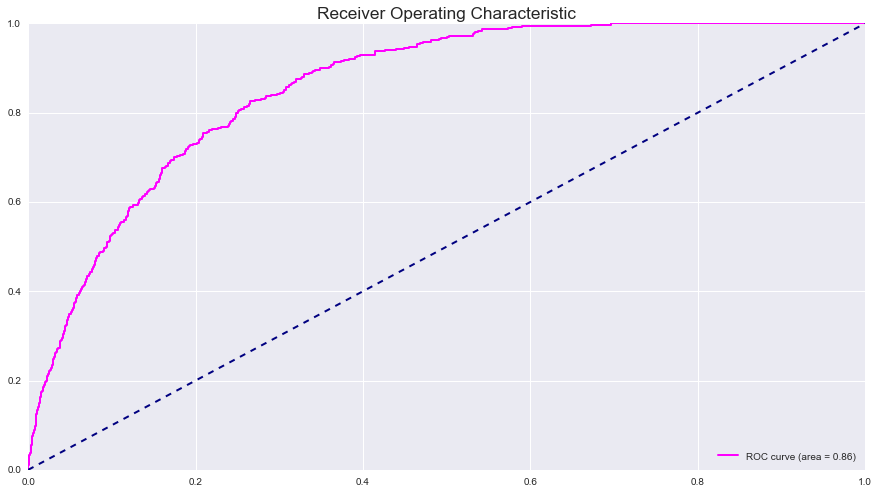

In [58]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(15,8))
plt.plot(fpr, tpr, color='magenta', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic', fontsize='xx-large')
plt.show()
#fig.savefig('ROC.png')

The area under the curve justifies that this is a good classifier.

## Error Analysis
We are interested in exploring the patients that the weighted logistic regression classifier has misclassified. In particular, because this classifier was trained without including any time variables, I am interested in seeing if there is a pattern within the time variables among the misclassified patients.

### Data import and cleaning

In [59]:
nancy = pd.read_csv("logreg_predicted.csv") #input file from weighted logreg jupyter notebook. This may be named something different
nancy.head()

,Unnamed: 0,ADMISSION_DATE,sex,Age,EDLOS,first_1_to_4_prio,nbr_ward_instances,TroponinT,Lactate,Hemoglobin,CRP,WBC,pH,occupancy,available_beds,ED_occupancy_x,IPLOS,hospital_death,class prediction,class prob
0,0,2003-05-01 15:26:00,1.0,30.0,3.066667,3.0,1.0,5.0,1.9,136.0,6.0,8.3,7.39,0.977949,154.0,40.900000,20.350000,0.0,0.0,0.021530
1,1,2004-02-06 11:56:00,1.0,28.8,1.216667,1.0,1.0,5.0,3.3,151.0,3.1,15.1,7.33,0.945065,152.0,51.016667,48.350000,0.0,0.0,0.104478
2,2,2005-02-05 12:46:00,1.0,73.7,2.600000,3.0,1.0,66.0,3.3,78.0,33.0,8.9,7.35,1.065901,159.0,56.233333,21.350000,0.0,1.0,0.597941
3,3,2004-11-16 16:03:00,0.0,45.4,2.713333,2.0,1.0,4.0,5.8,183.0,5.0,7.8,7.38,0.946250,161.0,33.400000,20.750000,0.0,0.0,0.155325
4,4,2003-07-27 22:45:00,0.0,87.3,3.550000,3.0,1.0,5.0,1.6,109.0,5.8,13.5,7.35,0.938571,152.0,40.016667,273.016667,0.0,1.0,0.581222


In order to analyze patterns in time variables, we need to make sure the time variables are in a format we can work with. The code below is for cleaning up the time data, creating a weekday variable to indicate what day of the week the patient was admitted, and creating indicator variables for whether or not that day was a weekend.

In [60]:
nancy['ADMISSION_DATE'] = pd.to_datetime(nancy['ADMISSION_DATE'])

In [61]:
nancy['weekday'] = nancy['ADMISSION_DATE'].apply(lambda x: x.weekday())
nancy.head()

,Unnamed: 0,ADMISSION_DATE,sex,Age,EDLOS,first_1_to_4_prio,nbr_ward_instances,TroponinT,Lactate,Hemoglobin,...,WBC,pH,occupancy,available_beds,ED_occupancy_x,IPLOS,hospital_death,class prediction,class prob,weekday
0,0,2003-05-01 15:26:00,1.0,30.0,3.066667,3.0,1.0,5.0,1.9,136.0,...,8.3,7.39,0.977949,154.0,40.900000,20.350000,0.0,0.0,0.021530,3
1,1,2004-02-06 11:56:00,1.0,28.8,1.216667,1.0,1.0,5.0,3.3,151.0,...,15.1,7.33,0.945065,152.0,51.016667,48.350000,0.0,0.0,0.104478,4
2,2,2005-02-05 12:46:00,1.0,73.7,2.600000,3.0,1.0,66.0,3.3,78.0,...,8.9,7.35,1.065901,159.0,56.233333,21.350000,0.0,1.0,0.597941,5
3,3,2004-11-16 16:03:00,0.0,45.4,2.713333,2.0,1.0,4.0,5.8,183.0,...,7.8,7.38,0.946250,161.0,33.400000,20.750000,0.0,0.0,0.155325,1
4,4,2003-07-27 22:45:00,0.0,87.3,3.550000,3.0,1.0,5.0,1.6,109.0,...,13.5,7.35,0.938571,152.0,40.016667,273.016667,0.0,1.0,0.581222,6


In [62]:
def weekday(row):
    if row['weekday'] <5:
        val = 1
    else:
        val = 0
    return val
    
nancy['weekday_binary'] = nancy.apply(weekday, axis=1)

In [63]:
nancy.head()

,Unnamed: 0,ADMISSION_DATE,sex,Age,EDLOS,first_1_to_4_prio,nbr_ward_instances,TroponinT,Lactate,Hemoglobin,...,pH,occupancy,available_beds,ED_occupancy_x,IPLOS,hospital_death,class prediction,class prob,weekday,weekday_binary
0,0,2003-05-01 15:26:00,1.0,30.0,3.066667,3.0,1.0,5.0,1.9,136.0,...,7.39,0.977949,154.0,40.900000,20.350000,0.0,0.0,0.021530,3,1
1,1,2004-02-06 11:56:00,1.0,28.8,1.216667,1.0,1.0,5.0,3.3,151.0,...,7.33,0.945065,152.0,51.016667,48.350000,0.0,0.0,0.104478,4,1
2,2,2005-02-05 12:46:00,1.0,73.7,2.600000,3.0,1.0,66.0,3.3,78.0,...,7.35,1.065901,159.0,56.233333,21.350000,0.0,1.0,0.597941,5,0
3,3,2004-11-16 16:03:00,0.0,45.4,2.713333,2.0,1.0,4.0,5.8,183.0,...,7.38,0.946250,161.0,33.400000,20.750000,0.0,0.0,0.155325,1,1
4,4,2003-07-27 22:45:00,0.0,87.3,3.550000,3.0,1.0,5.0,1.6,109.0,...,7.35,0.938571,152.0,40.016667,273.016667,0.0,1.0,0.581222,6,0


Now, we separate out the people who were misclassified by the weighted logistic regression classifier.

In [64]:
misclassified_df = nancy[nancy['class prediction'] != nancy['hospital_death']]
misclassified_df.head()

,Unnamed: 0,ADMISSION_DATE,sex,Age,EDLOS,first_1_to_4_prio,nbr_ward_instances,TroponinT,Lactate,Hemoglobin,...,pH,occupancy,available_beds,ED_occupancy_x,IPLOS,hospital_death,class prediction,class prob,weekday,weekday_binary
2,2,2005-02-05 12:46:00,1.0,73.7,2.600000,3.0,1.0,66.0,3.3,78.0,...,7.35,1.065901,159.0,56.233333,21.350000,0.0,1.0,0.597941,5,0
4,4,2003-07-27 22:45:00,0.0,87.3,3.550000,3.0,1.0,5.0,1.6,109.0,...,7.35,0.938571,152.0,40.016667,273.016667,0.0,1.0,0.581222,6,0
10,11,2005-02-08 22:09:00,1.0,68.3,1.213333,1.0,1.0,37.0,2.4,148.0,...,7.40,0.984512,163.0,28.600000,40.650000,0.0,1.0,0.544715,1,1
15,18,2005-02-18 10:59:00,0.0,85.3,5.513333,3.0,2.0,4.0,1.7,116.0,...,7.41,0.990000,165.0,45.300000,235.250000,0.0,1.0,0.596693,4,1
22,28,2004-02-28 14:58:00,1.0,54.0,3.163333,1.0,1.0,6.0,12.7,150.0,...,7.21,1.021494,153.0,37.316667,18.150000,0.0,1.0,0.929205,5,0


We further separate the misclassified into those who truly survived (but were classified as dead), and those who truly died (but were classified as alive).

In [65]:
misclassified0 = misclassified_df[misclassified_df['hospital_death'] == 0.0] #People who actually survived 
misclassified1 = misclassified_df[misclassified_df['hospital_death'] == 1.0] #People who actually died

In [66]:
misclassified0.describe()

,Unnamed: 0,sex,Age,EDLOS,first_1_to_4_prio,nbr_ward_instances,TroponinT,Lactate,Hemoglobin,CRP,...,pH,occupancy,available_beds,ED_occupancy_x,IPLOS,hospital_death,class prediction,class prob,weekday,weekday_binary
count,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,...,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.0,9660.0,9660.000000,9660.000000,9660.000000
mean,20009.134369,0.545031,78.156253,3.373708,2.107453,1.308178,35.598033,2.702070,123.207246,53.477649,...,7.380970,0.974552,154.917909,36.795970,174.361529,0.0,1.0,0.657099,2.987164,0.709420
std,11556.810672,0.497994,9.625868,1.718694,0.789887,0.628511,180.953363,1.838597,22.498413,83.045689,...,0.069946,0.055579,4.626386,12.522374,204.322103,0.0,0.0,0.142172,2.033787,0.454053
min,2.000000,0.000000,15.700000,0.296667,1.000000,1.000000,4.000000,0.800000,24.000000,1.200000,...,6.670000,0.749740,128.000000,9.683333,-0.083333,0.0,1.0,0.450004,0.000000,0.000000
25%,9923.500000,0.000000,72.800000,2.116667,2.000000,1.000000,5.000000,1.800000,110.000000,6.000000,...,7.350000,0.943571,152.000000,27.562500,45.900000,0.0,1.0,0.535792,1.000000,0.000000
50%,20082.500000,1.000000,79.900000,3.063333,2.000000,1.000000,6.000000,2.100000,125.000000,13.000000,...,7.390000,0.982105,153.000000,36.991667,112.500000,0.0,1.0,0.635068,3.000000,1.000000
75%,30000.500000,1.000000,84.900000,4.296667,3.000000,1.000000,25.000000,2.900000,138.000000,64.000000,...,7.420000,1.010000,157.000000,45.383333,240.625000,0.0,1.0,0.761249,5.000000,1.000000
max,39997.000000,1.000000,101.900000,14.880000,5.000000,8.000000,7199.000000,30.600000,207.000000,595.000000,...,7.720000,1.131883,172.000000,79.450000,4516.733333,0.0,1.0,0.999987,6.000000,1.000000


In [67]:
misclassified1.describe()

,Unnamed: 0,sex,Age,EDLOS,first_1_to_4_prio,nbr_ward_instances,TroponinT,Lactate,Hemoglobin,CRP,...,pH,occupancy,available_beds,ED_occupancy_x,IPLOS,hospital_death,class prediction,class prob,weekday,weekday_binary
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,...,171.000000,171.000000,171.000000,171.000000,171.000000,171.0,171.0,171.000000,171.000000,171.000000
mean,19723.666667,0.514620,68.245614,3.971131,2.678363,1.157895,11.421053,2.130994,132.970760,33.851462,...,7.379532,0.968452,155.479532,39.005068,149.285283,1.0,0.0,0.322760,2.719298,0.795322
std,11791.636262,0.501254,12.085865,2.280682,0.943429,0.396580,30.824902,0.853249,21.729196,58.665685,...,0.078484,0.054241,4.413001,13.013650,157.227928,0.0,0.0,0.098122,1.891974,0.404651
min,101.000000,0.000000,25.000000,0.546667,1.000000,1.000000,4.000000,1.000000,76.000000,1.300000,...,6.760000,0.774740,149.000000,14.233333,0.566667,1.0,0.0,0.068373,0.000000,0.000000
25%,9141.000000,0.000000,61.900000,2.100000,2.000000,1.000000,4.000000,1.700000,120.000000,5.000000,...,7.365000,0.938052,152.000000,29.066667,39.041667,1.0,0.0,0.256677,1.000000,1.000000
50%,20079.000000,1.000000,69.100000,3.613333,3.000000,1.000000,5.000000,1.900000,138.000000,7.000000,...,7.390000,0.976039,155.000000,39.483333,99.733333,1.0,0.0,0.348349,3.000000,1.000000
75%,29225.000000,1.000000,75.450000,5.115000,3.000000,1.000000,6.000000,2.300000,143.000000,33.500000,...,7.410000,1.003787,157.000000,48.108333,205.908333,1.0,0.0,0.402049,4.000000,1.000000
max,39957.000000,1.000000,92.700000,11.883333,5.000000,3.000000,360.000000,10.100000,198.000000,394.000000,...,7.510000,1.098333,169.000000,71.750000,1098.200000,1.0,0.0,0.449460,6.000000,1.000000


9,820 patients actually survived, but were misclassified as a hospital death, whereas 156 people actually died but were misclassified as a survival. This imbalance makes sense, since the classifier was modified to increase false positives.

## Predicted probabilities output by classifier 
I plot a histogram of the predicted probabilites output by the classifier, stratified by those who truly survived and those who truly died. The vertical line indicates the chosen threshold for the weighted logreg classifier, which was p = 0.45.


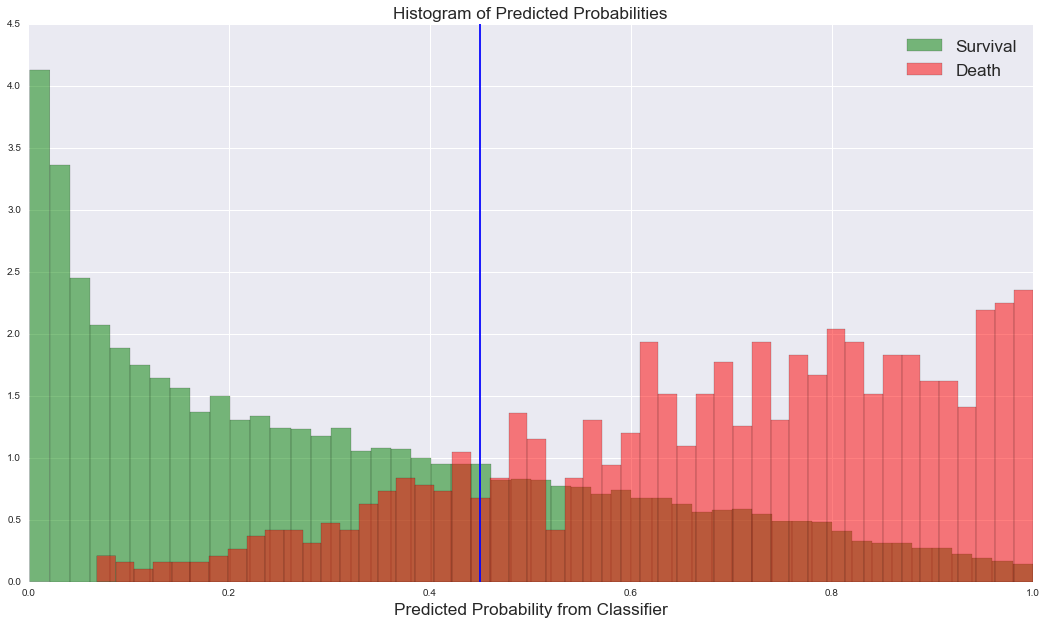

In [68]:
fig = plt.figure(figsize=(18,10))
plt.hist(nancy[nancy['hospital_death'] == 0.0]['class prob'].values, alpha= 0.5, normed=True, bins=50, color='green', label='Survival')
plt.hist(nancy[nancy['hospital_death'] == 1.0]['class prob'].values, alpha = 0.5, normed=True, bins=50, color='red', label='Death')
plt.axvline(x=0.45)
plt.legend(fontsize='xx-large')
plt.xlabel('Predicted Probability from Classifier', fontsize='xx-large')
plt.title('Histogram of Predicted Probabilities', fontsize='xx-large')
plt.show()
#fig.savefig('predicted_probabilities.png')

We see that this threshold chosen is nearly at the minimum of the curve outlined by both probability distributions. We do not have a clear separation of the distributions of predicted probabilities stratified by true outcome.

## Examining the distribution of various features and biomarkers for those who were misclassified, stratified by their true outcome.## 
It would be interesting to further examine our classifier to determine if there are interesting patterns in what kinds of patients were likely to be misclassified. We look at the different distributions of certain biomarkers and lab test results for those misclassified by the weighted logreg classifier, stratified on their true outcome.
Certain properties were selected as indicated by their importance in random forest classifier: age, pH, Troponin, Lactate, Hemoglobin, CRP. 
We also look at measures of hospital experience: hospital occupancy rate, emegency department length of stay, and in patient length of stay.

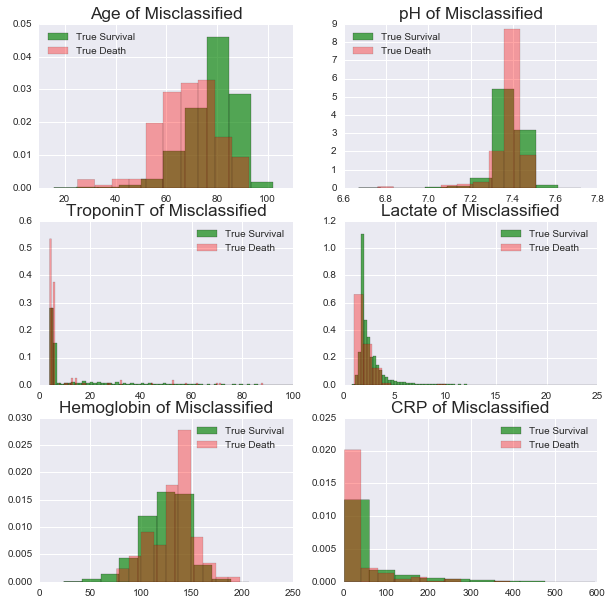

In [69]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(3,2,1)
ax1.hist(misclassified0['Age'].values, alpha=0.65, normed=True, color='green', label='True Survival')
ax1.hist(misclassified1['Age'].values, alpha = 0.35, normed=True, color='red', label='True Death')
ax1.legend(loc='best')
ax1.set_title('Age of Misclassified', fontsize='xx-large')

ax2 = fig.add_subplot(3,2,2)
ax2.hist(misclassified0['pH'].values, alpha=0.65, normed=True, color='green', label='True Survival')
ax2.hist(misclassified1['pH'].values, alpha = 0.35, normed=True, color='red', label='True Death')
ax2.legend(loc='best')
ax2.set_title('pH of Misclassified', fontsize='xx-large')

ax3 = fig.add_subplot(3,2,3)
ax3.hist(misclassified0['TroponinT'].values, alpha=0.65, normed=True, color='green', bins = 5000, label='True Survival')
ax3.hist(misclassified1['TroponinT'].values, alpha = 0.35, normed=True, color='red', bins = 500, label='True Death')
ax3.set_xlim((0,100))
ax3.legend()
ax3.set_title('TroponinT of Misclassified', fontsize='xx-large')

ax4 = fig.add_subplot(3,2,4)
ax4.hist(misclassified0['Lactate'].values, alpha= 0.65, normed=True, color='green', bins=100, label='True Survival')
ax4.hist(misclassified1['Lactate'].values, alpha = 0.35, normed=True, color='red', bins=10, label='True Death')
ax4.set_xlim((0,25))
ax4.legend()
ax4.set_title('Lactate of Misclassified', fontsize='xx-large')

ax5 = fig.add_subplot(3,2,5)
ax5.hist(misclassified0['Hemoglobin'].values, alpha= 0.65, normed=True, color='green', label='True Survival')
ax5.hist(misclassified1['Hemoglobin'].values, alpha = 0.35, normed=True, color='red', label='True Death')
ax5.legend()
ax5.set_title('Hemoglobin of Misclassified', fontsize='xx-large')

ax6 = fig.add_subplot(3,2,6)
ax6.hist(misclassified0['CRP'].values, alpha= 0.65, normed=True, color='green', label='True Survival')
ax6.hist(misclassified1['CRP'].values, alpha = 0.35, normed=True, color='red', label='True Death')
ax6.legend()
ax6.set_title('CRP of Misclassified', fontsize='xx-large')


plt.show()
#fig.savefig('lab_metrics.png')

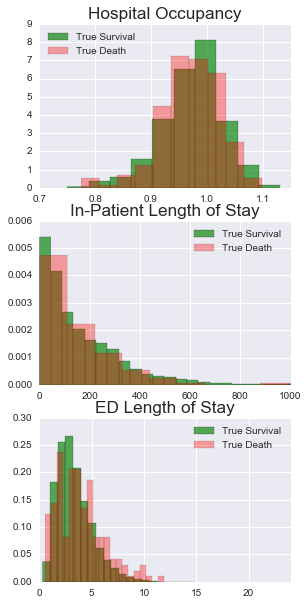

In [70]:
fig = plt.figure(figsize=(4.5,10))
ax1 = fig.add_subplot(3,1,1)
ax1.hist(misclassified0['occupancy'].values, alpha= 0.65, normed=True, color='green', label='True Survival')
ax1.hist(misclassified1['occupancy'].values, alpha = 0.35, normed=True, color='red', label='True Death')
ax1.legend(loc='best')
ax1.set_title('Hospital Occupancy', fontsize='xx-large')

ax2 = fig.add_subplot(3,1,2)
ax2.hist(misclassified0['IPLOS'].values, alpha=0.65, normed=True, color='green', bins=100, label='True Survival')
ax2.hist(misclassified1['IPLOS'].values, alpha = 0.35, normed=True, color='red', label='True Death')
ax2.set_xlim((0,1000))
ax2.legend(loc='best')
ax2.set_title('In-Patient Length of Stay', fontsize='xx-large')

ax3 = fig.add_subplot(3,1,3)
ax3.hist(misclassified0['EDLOS'].values, alpha=0.65, normed=True, color='green', bins =20, label='True Survival')
ax3.hist(misclassified1['EDLOS'].values, alpha = 0.35, normed=True, color='red', bins = 20, label='True Death')
ax3.set_xlim((0,24))
ax3.legend(loc='best')
ax3.set_title('ED Length of Stay', fontsize='xx-large')

plt.show()
#fig.savefig('hospital_metrics.png')

We can see that the age of those who truly survived is slightly higher than the age of those who actually experienced hospital death. This makes sense given age is an important predictor of outcome, and that older individuals are more likely to be extremely sick and more likely classified as a hospital death. 

## Time variable analysis for misclassified points
**Now, the question of interest is: is there a pattern in what weekdays, or other time factors, are more likely to be misclassified than others?**

In [71]:
misclassified_by_weekday = misclassified_df.groupby('weekday').size().values
visits_weekday = nancy.groupby('weekday').size().values

First, for each weekday, we calculate the number of people who survived and died. 

In [72]:
# Need number of people who survived and died on each weekday
no_survived_weekday = []
no_died_weekday = []
for i in range(7):
    survived = np.sum(nancy[nancy['weekday'] == i]['hospital_death'] == 0.0)
    died = np.sum(nancy[nancy['weekday'] == i]['hospital_death'] == 1.0)
    no_survived_weekday.append(survived)
    no_died_weekday.append(died)
print no_survived_weekday
print no_died_weekday

[4902, 4916, 4307, 4414, 5304, 4906, 5035]
[139, 145, 132, 153, 156, 159, 144]


Plot proportion of people misclassified per weekday.

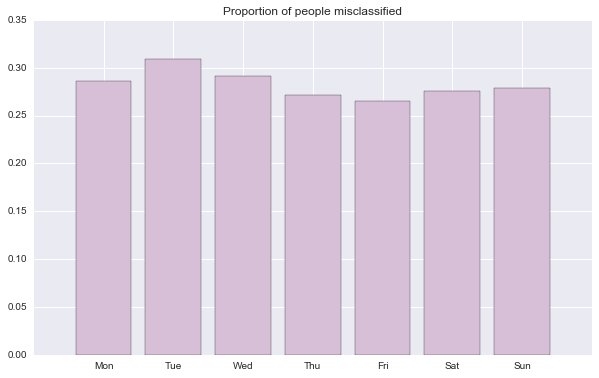

In [73]:
plt.bar(list(range(7)), np.divide(misclassified_by_weekday.astype('float'), visits_weekday.astype('float')), align='center', color='thistle')
plt.xticks(list(range(7)), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Proportion of people misclassified')
plt.show()

The proportion of people misclassified looks pretty similar across all weekdays. We would need to do a hypothesis test to conclude anything of significance.

We should stratify the above plot by those who actually survived and those who actually died.

In [74]:
misclassified0_by_weekday = misclassified0.groupby('weekday').size().values
misclassified1_by_weekday = misclassified1.groupby('weekday').size().values

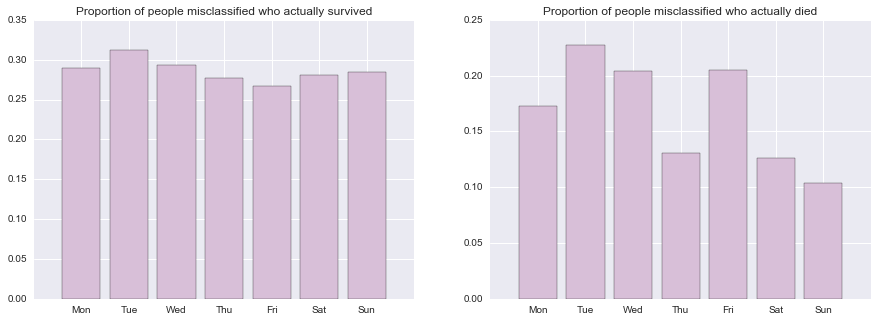

In [75]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax1.bar(list(range(7)), np.divide(misclassified0_by_weekday.astype('float'), no_survived_weekday), align='center', color='thistle')
ax1.set_xticks(list(range(7)))
ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax1.set_title('Proportion of people misclassified who actually survived')

ax2 = fig.add_subplot(1,2,2)
ax2.bar(list(range(7)), np.divide(misclassified1_by_weekday.astype('float'), no_died_weekday), align='center', color='thistle')
ax2.set_xticks(list(range(7)))
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax2.set_title('Proportion of people misclassified who actually died')

plt.show()

Among those who actually survived, the misclassification looks pretty similar across all weekdays. However, this is not necessarily the case for people who actually died: the number of people misclassified who actually died divided by the total number of people who died that day varies across the weekdays. However, we note that we have a smaller sample of those people who actually died, so the results may not be statistically significant or achieve sufficient power.

To get an overall sense of the hospital admission over time, I plot a histogram of the admission dates in our dataset.

In [76]:
admit_dates = list(nancy['ADMISSION_DATE'].values)
hospital_death = nancy['hospital_death'].values
predicted = nancy['class prediction'].values

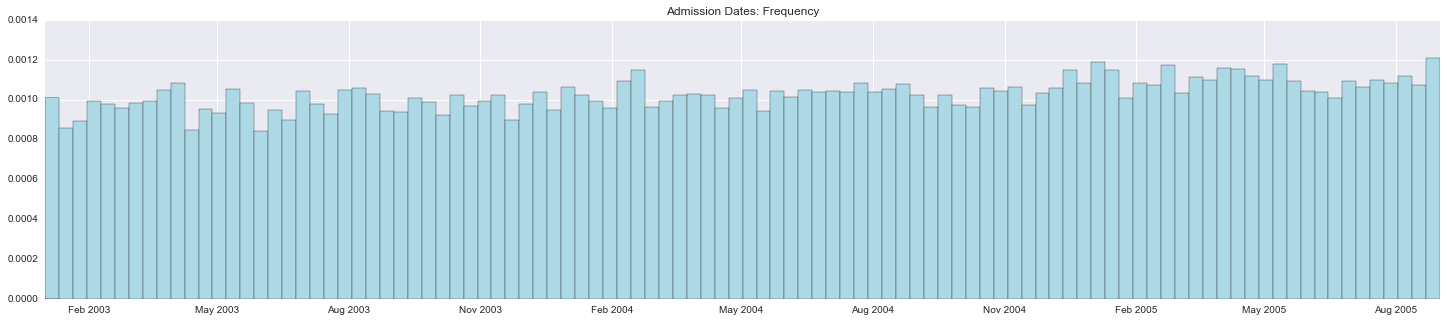

In [77]:
fig = plt.figure(figsize=(25,5))
plt.hist(admit_dates, bins=100, color='lightblue', normed=True)
plt.title('Admission Dates: Frequency')
plt.show()

The distribution of admission dates in our dataset looks uniform.

Now, we want to analyze the distribution of misclassified points over time. This will involve some preliminary data cleaning again, so that we can sort the data by specific month and year.

First, strip time- we are just interested in the date.

In [78]:
misclassified_df['just_date'] = misclassified_df['ADMISSION_DATE'].dt.date

/Users/isabelle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [79]:
misclassified_df.head()

,Unnamed: 0,ADMISSION_DATE,sex,Age,EDLOS,first_1_to_4_prio,nbr_ward_instances,TroponinT,Lactate,Hemoglobin,...,occupancy,available_beds,ED_occupancy_x,IPLOS,hospital_death,class prediction,class prob,weekday,weekday_binary,just_date
2,2,2005-02-05 12:46:00,1.0,73.7,2.600000,3.0,1.0,66.0,3.3,78.0,...,1.065901,159.0,56.233333,21.350000,0.0,1.0,0.597941,5,0,2005-02-05
4,4,2003-07-27 22:45:00,0.0,87.3,3.550000,3.0,1.0,5.0,1.6,109.0,...,0.938571,152.0,40.016667,273.016667,0.0,1.0,0.581222,6,0,2003-07-27
10,11,2005-02-08 22:09:00,1.0,68.3,1.213333,1.0,1.0,37.0,2.4,148.0,...,0.984512,163.0,28.600000,40.650000,0.0,1.0,0.544715,1,1,2005-02-08
15,18,2005-02-18 10:59:00,0.0,85.3,5.513333,3.0,2.0,4.0,1.7,116.0,...,0.990000,165.0,45.300000,235.250000,0.0,1.0,0.596693,4,1,2005-02-18
22,28,2004-02-28 14:58:00,1.0,54.0,3.163333,1.0,1.0,6.0,12.7,150.0,...,1.021494,153.0,37.316667,18.150000,0.0,1.0,0.929205,5,0,2004-02-28


Make a new column that labels the month and the year the patient entered the dataset. 

In [80]:
misclassified_df['month_year'] = misclassified_df['ADMISSION_DATE'].apply(lambda x: x.strftime('%B-%Y'))

/Users/isabelle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [81]:
misclassified_df.head()

,Unnamed: 0,ADMISSION_DATE,sex,Age,EDLOS,first_1_to_4_prio,nbr_ward_instances,TroponinT,Lactate,Hemoglobin,...,available_beds,ED_occupancy_x,IPLOS,hospital_death,class prediction,class prob,weekday,weekday_binary,just_date,month_year
2,2,2005-02-05 12:46:00,1.0,73.7,2.600000,3.0,1.0,66.0,3.3,78.0,...,159.0,56.233333,21.350000,0.0,1.0,0.597941,5,0,2005-02-05,February-2005
4,4,2003-07-27 22:45:00,0.0,87.3,3.550000,3.0,1.0,5.0,1.6,109.0,...,152.0,40.016667,273.016667,0.0,1.0,0.581222,6,0,2003-07-27,July-2003
10,11,2005-02-08 22:09:00,1.0,68.3,1.213333,1.0,1.0,37.0,2.4,148.0,...,163.0,28.600000,40.650000,0.0,1.0,0.544715,1,1,2005-02-08,February-2005
15,18,2005-02-18 10:59:00,0.0,85.3,5.513333,3.0,2.0,4.0,1.7,116.0,...,165.0,45.300000,235.250000,0.0,1.0,0.596693,4,1,2005-02-18,February-2005
22,28,2004-02-28 14:58:00,1.0,54.0,3.163333,1.0,1.0,6.0,12.7,150.0,...,153.0,37.316667,18.150000,0.0,1.0,0.929205,5,0,2004-02-28,February-2004


Get the counts of patients in each month-year category, i.e. how many patients were admitted in February 2003? In March 2003? And etcetera. We want to do this for entire dataset and for those misclassified.

In [82]:
misclassified_by_monthyear = misclassified_df.groupby('month_year').size() #Pandas series
misclassified_by_monthyear_values = misclassified_by_monthyear.values

In [83]:
# Do this for main dataset 
nancy['month_year'] = nancy['ADMISSION_DATE'].apply(lambda x: x.strftime('%B-%Y'))
visits_by_monthyear = nancy.groupby('month_year').size() #Pandas series
visits_by_monthyear_values = nancy.groupby('month_year').size().values

Double check that our counting process worked. 

In [84]:
print misclassified_by_monthyear

month_year
April-2003        275
April-2004        305
April-2005        375
August-2003       292
August-2004       317
August-2005       361
December-2003     313
December-2004     336
February-2003     245
February-2004     325
February-2005     343
January-2003      298
January-2004      294
January-2005      398
July-2003         292
July-2004         307
July-2005         302
June-2003         235
June-2004         304
June-2005         323
March-2003        282
March-2004        318
March-2005        320
May-2003          327
May-2004          298
May-2005          378
November-2003     245
November-2004     313
October-2003      277
October-2004      292
September-2003    273
September-2004    268
dtype: int64


Now, we just have to order these values chronologically.
I could not find a quick way to do this automatically; it ended up being faster to just reorder these by hand, which I did not enjoy, but the job was done.

In [85]:
monthyear_ordered = [
    misclassified_by_monthyear.index.values[11], #jan 2003
    misclassified_by_monthyear.index.values[8],
    misclassified_by_monthyear.index.values[20],
    misclassified_by_monthyear.index.values[0], # april 2003
    misclassified_by_monthyear.index.values[23],
    misclassified_by_monthyear.index.values[17],
    misclassified_by_monthyear.index.values[14],
    misclassified_by_monthyear.index.values[3],
    misclassified_by_monthyear.index.values[30], #september
    misclassified_by_monthyear.index.values[28],
    misclassified_by_monthyear.index.values[26],
    misclassified_by_monthyear.index.values[6], # December 2003
    misclassified_by_monthyear.index.values[12], # January 2004
    misclassified_by_monthyear.index.values[9],
    misclassified_by_monthyear.index.values[21],
    misclassified_by_monthyear.index.values[1],
    misclassified_by_monthyear.index.values[24],
    misclassified_by_monthyear.index.values[18],
    misclassified_by_monthyear.index.values[15],
    misclassified_by_monthyear.index.values[4], # august 2004
    misclassified_by_monthyear.index.values[31],
    misclassified_by_monthyear.index.values[29],
    misclassified_by_monthyear.index.values[27],
    misclassified_by_monthyear.index.values[7], # December 2004
    misclassified_by_monthyear.index.values[13], # January 2005
    misclassified_by_monthyear.index.values[10],# Febuary 2005
    misclassified_by_monthyear.index.values[22],
    misclassified_by_monthyear.index.values[2],
    misclassified_by_monthyear.index.values[25],
    misclassified_by_monthyear.index.values[19],
    misclassified_by_monthyear.index.values[16],
    misclassified_by_monthyear.index.values[5],
] 
print monthyear_ordered

['January-2003', 'February-2003', 'March-2003', 'April-2003', 'May-2003', 'June-2003', 'July-2003', 'August-2003', 'September-2003', 'October-2003', 'November-2003', 'December-2003', 'January-2004', 'February-2004', 'March-2004', 'April-2004', 'May-2004', 'June-2004', 'July-2004', 'August-2004', 'September-2004', 'October-2004', 'November-2004', 'December-2004', 'January-2005', 'February-2005', 'March-2005', 'April-2005', 'May-2005', 'June-2005', 'July-2005', 'August-2005']


We can now find the proportion misclassified in each month by dividing the number misclassified in each month by the number of visits in each month. I will have to again reorder these by hand, but the good news is we can keep the ordering structure used above, and just change the name of the list we want to reorder.

In [86]:
proportion_misclassified_by_monthyear = np.divide(misclassified_by_monthyear_values.astype('float'), visits_by_monthyear_values.astype('float'))
print proportion_misclassified_by_monthyear
print 'length', len(proportion_misclassified_by_monthyear)

[ 0.27777778  0.28800755  0.30712531  0.26666667  0.2770979   0.2956593
  0.29225023  0.28791774  0.25467775  0.30317164  0.31671283  0.30284553
  0.26775956  0.33194329  0.27495292  0.26953468  0.25900515  0.24352332
  0.28096118  0.30046512  0.25847846  0.29014599  0.2739726   0.30733083
  0.27643785  0.31871838  0.245       0.29279701  0.26206244  0.26118068
  0.26843658  0.26456071]
length 32


In [87]:
proportion_misclassified_ordered = [
    proportion_misclassified_by_monthyear[11], #jan 2003
    proportion_misclassified_by_monthyear[8],
    proportion_misclassified_by_monthyear[20],
    proportion_misclassified_by_monthyear[0], # april 2003
    proportion_misclassified_by_monthyear[23],
    proportion_misclassified_by_monthyear[17],
    proportion_misclassified_by_monthyear[14],
    proportion_misclassified_by_monthyear[3],
    proportion_misclassified_by_monthyear[30], #september
    proportion_misclassified_by_monthyear[28],
    proportion_misclassified_by_monthyear[26],
    proportion_misclassified_by_monthyear[6], # December 2003
    proportion_misclassified_by_monthyear[12], # January 2004
    proportion_misclassified_by_monthyear[9],
    proportion_misclassified_by_monthyear[21],
    proportion_misclassified_by_monthyear[1],
    proportion_misclassified_by_monthyear[24],
    proportion_misclassified_by_monthyear[18],
    proportion_misclassified_by_monthyear[15],
    proportion_misclassified_by_monthyear[4], # august 2004
    proportion_misclassified_by_monthyear[31],
    proportion_misclassified_by_monthyear[29],
    proportion_misclassified_by_monthyear[27],
    proportion_misclassified_by_monthyear[7], # December 2004
    proportion_misclassified_by_monthyear[13], # January 2005
    proportion_misclassified_by_monthyear[10],# Febuary 2005
    proportion_misclassified_by_monthyear[22],
    proportion_misclassified_by_monthyear[2],
    proportion_misclassified_by_monthyear[25],
    proportion_misclassified_by_monthyear[19],
    proportion_misclassified_by_monthyear[16],
    proportion_misclassified_by_monthyear[5],
] 

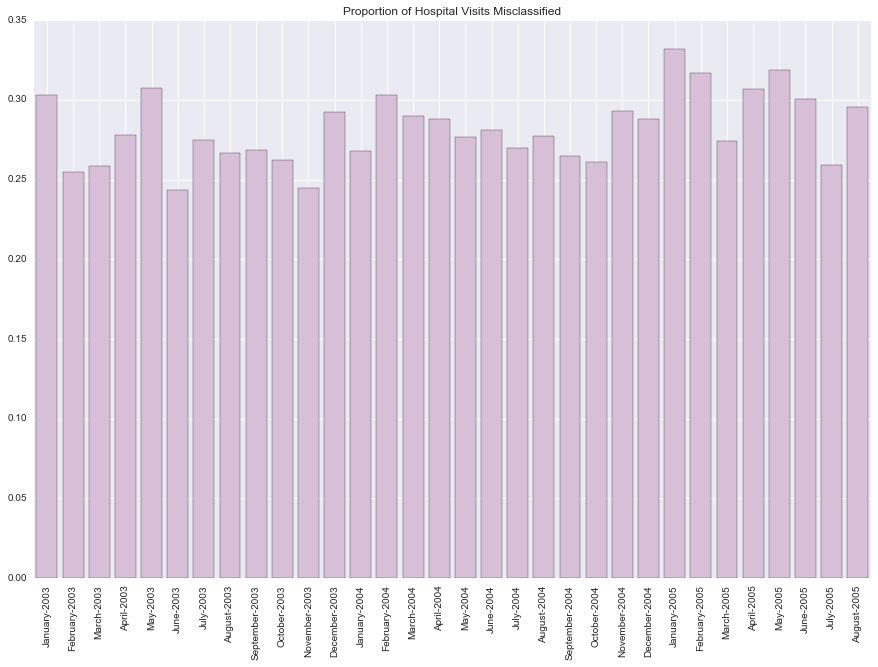

In [88]:
fig = plt.figure(figsize=(15,10))
plt.bar(list(range(32)), proportion_misclassified_ordered, align='center', color='thistle')
plt.xticks(list(range(32)), monthyear_ordered, rotation='vertical')
plt.xlim([-0.5, 31.5])
plt.title('Proportion of Hospital Visits Misclassified')
plt.show()
#fig.savefig('misclassified_overtime.png')

Now, we break down this analysis by those who actually survived and those who actually died.

In [89]:
misclassified0['month_year'] = misclassified0['ADMISSION_DATE'].apply(lambda x: x.strftime('%B-%Y'))
misclassified1['month_year'] = misclassified1['ADMISSION_DATE'].apply(lambda x: x.strftime('%B-%Y'))


misclassified0_by_monthyear = misclassified0.groupby('month_year').size() #Pandas series
misclassified0_by_monthyear_values = misclassified0_by_monthyear.values

misclassified1_by_monthyear = misclassified1.groupby('month_year').size() #Pandas series
misclassified1_by_monthyear_values = misclassified1_by_monthyear.values

/Users/isabelle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/isabelle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In order to do this, we need to tabulate the number of survivals and deaths in each month over the 3 years.
We can then calculate the proportion of those who survived that were misclassified, and the proportion of those who died that were misclassified.

In [90]:
# Need to create survivals, deaths by monthyear
survivals_by_monthyear = nancy[nancy['hospital_death'] == 0.0].groupby('month_year').size() #Pandas series
survivals_by_monthyear_values = survivals_by_monthyear.values

deaths_by_monthyear = nancy[nancy['hospital_death'] == 1.0].groupby('month_year').size()
deaths_by_monthyear_values = deaths_by_monthyear.values

proportion_misclassified0_by_monthyear = np.divide(misclassified0_by_monthyear_values.astype('float'), survivals_by_monthyear_values.astype('float'))
proportion_misclassified1_by_monthyear = np.divide(misclassified1_by_monthyear_values.astype('float'), deaths_by_monthyear_values.astype('float'))


print proportion_misclassified0_by_monthyear
print proportion_misclassified1_by_monthyear

# print proportion_misclassified_by_monthyear
# print 'length', len(proportion_misclassified_by_monthyear)

[ 0.28197065  0.29406037  0.31148936  0.2731569   0.27648115  0.29756915
  0.29361296  0.29406554  0.25665602  0.3096836   0.31953802  0.30712788
  0.26991565  0.33707865  0.27837051  0.27403414  0.25854514  0.24226254
  0.28258801  0.30057252  0.26255924  0.29605263  0.27956989  0.31195335
  0.27840909  0.32380952  0.24795082  0.29797493  0.26614481  0.26728111
  0.26849037  0.2716175 ]
[ 0.16666667  0.09375     0.19565217  0.08108108  0.3         0.21428571
  0.22727273  0.10526316  0.17391304  0.06896552  0.25        0.16666667
  0.19354839  0.19047619  0.16129032  0.07692308  0.28        0.28571429
  0.22580645  0.2962963   0.13888889  0.09375     0.15384615  0.17142857
  0.18181818  0.12903226  0.125       0.125       0.14285714  0.06060606
  0.26666667  0.03333333]


Same as we've done previously, we now need to order these lists.

In [91]:
proportion_misclassified0_ordered = [
    proportion_misclassified0_by_monthyear[11], #jan 2003
    proportion_misclassified0_by_monthyear[8],
    proportion_misclassified0_by_monthyear[20],
    proportion_misclassified0_by_monthyear[0], # april 2003
    proportion_misclassified0_by_monthyear[23],
    proportion_misclassified0_by_monthyear[17],
    proportion_misclassified0_by_monthyear[14],
    proportion_misclassified0_by_monthyear[3],
    proportion_misclassified0_by_monthyear[30], #september
    proportion_misclassified0_by_monthyear[28],
    proportion_misclassified0_by_monthyear[26],
    proportion_misclassified0_by_monthyear[6], # December 2003
    proportion_misclassified0_by_monthyear[12], # January 2004
    proportion_misclassified0_by_monthyear[9],
    proportion_misclassified0_by_monthyear[21],
    proportion_misclassified0_by_monthyear[1],
    proportion_misclassified0_by_monthyear[24],
    proportion_misclassified0_by_monthyear[18],
    proportion_misclassified0_by_monthyear[15],
    proportion_misclassified0_by_monthyear[4], # august 2004
    proportion_misclassified0_by_monthyear[31],
    proportion_misclassified0_by_monthyear[29],
    proportion_misclassified0_by_monthyear[27],
    proportion_misclassified0_by_monthyear[7], # December 2004
    proportion_misclassified0_by_monthyear[13], # January 2005
    proportion_misclassified0_by_monthyear[10],# Febuary 2005
    proportion_misclassified0_by_monthyear[22],
    proportion_misclassified0_by_monthyear[2],
    proportion_misclassified0_by_monthyear[25],
    proportion_misclassified0_by_monthyear[19],
    proportion_misclassified0_by_monthyear[16],
    proportion_misclassified0_by_monthyear[5],
]

proportion_misclassified1_ordered = [
    proportion_misclassified1_by_monthyear[11], #jan 2003
    proportion_misclassified1_by_monthyear[8],
    proportion_misclassified1_by_monthyear[20],
    proportion_misclassified1_by_monthyear[0], # april 2003
    proportion_misclassified1_by_monthyear[23],
    proportion_misclassified1_by_monthyear[17],
    proportion_misclassified1_by_monthyear[14],
    proportion_misclassified1_by_monthyear[3],
    proportion_misclassified1_by_monthyear[30], #september
    proportion_misclassified1_by_monthyear[28],
    proportion_misclassified1_by_monthyear[26],
    proportion_misclassified1_by_monthyear[6], # December 2003
    proportion_misclassified1_by_monthyear[12], # January 2004
    proportion_misclassified1_by_monthyear[9],
    proportion_misclassified1_by_monthyear[21],
    proportion_misclassified1_by_monthyear[1],
    proportion_misclassified1_by_monthyear[24],
    proportion_misclassified1_by_monthyear[18],
    proportion_misclassified1_by_monthyear[15],
    proportion_misclassified1_by_monthyear[4], # august 2004
    proportion_misclassified1_by_monthyear[31],
    proportion_misclassified1_by_monthyear[29],
    proportion_misclassified1_by_monthyear[27],
    proportion_misclassified1_by_monthyear[7], # December 2004
    proportion_misclassified1_by_monthyear[13], # January 2005
    proportion_misclassified1_by_monthyear[10],# Febuary 2005
    proportion_misclassified1_by_monthyear[22],
    proportion_misclassified1_by_monthyear[2],
    proportion_misclassified1_by_monthyear[25],
    proportion_misclassified1_by_monthyear[19],
    proportion_misclassified1_by_monthyear[16],
    proportion_misclassified1_by_monthyear[5],
] 

We generate plots to visualize our results.

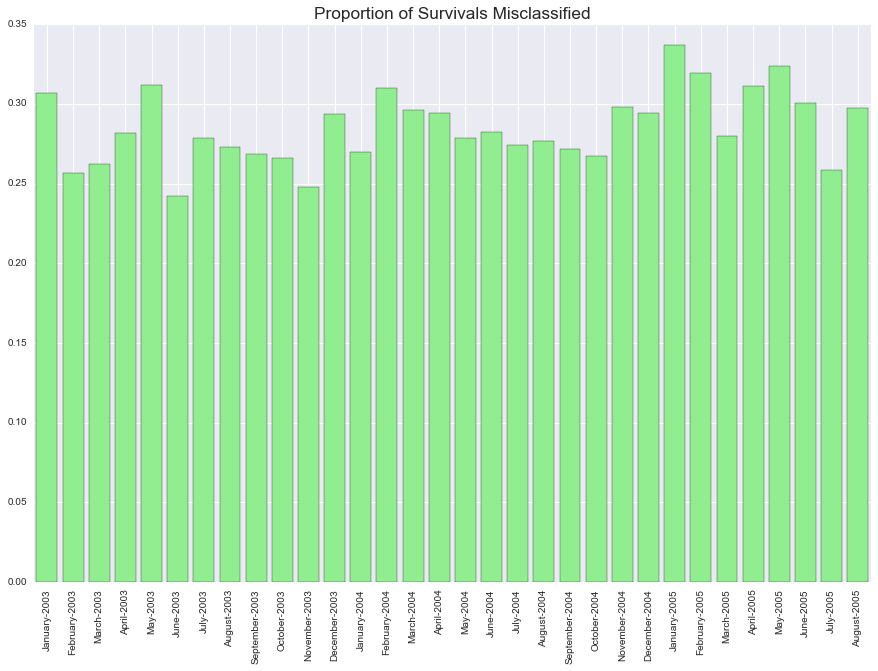

In [92]:
fig = plt.figure(figsize=(15,10))
plt.bar(list(range(32)), proportion_misclassified0_ordered, align='center', color='lightgreen')
plt.xticks(list(range(32)), monthyear_ordered, rotation='vertical')
plt.xlim([-0.5, 31.5])
plt.title('Proportion of Survivals Misclassified', fontsize='xx-large')
plt.show()

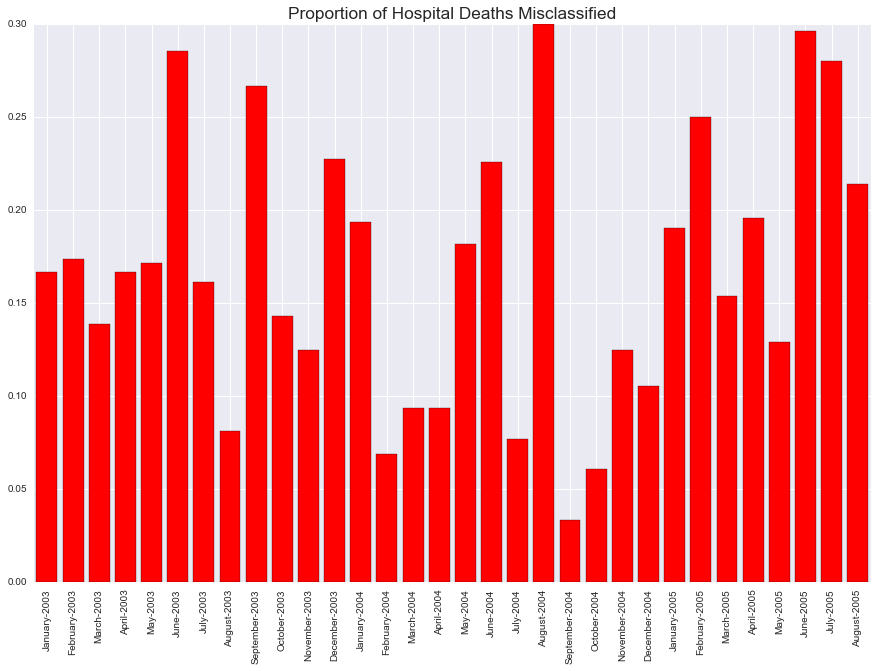

In [93]:
fig = plt.figure(figsize=(15,10))
plt.bar(list(range(32)), proportion_misclassified1_ordered, align='center', color='red')
plt.xticks(list(range(32)), monthyear_ordered, rotation='vertical')
plt.xlim([-0.5, 31.5])
plt.title('Proportion of Hospital Deaths Misclassified', fontsize='xx-large')
plt.show()

The proportion of survivals misclassified is much more uniformly distributed than the proportion of deaths misclassified over time. However, we note that we have a smaller sample size for hospital deaths, so we cannot yet conclude anything of statistical significance.

# <font color = 'blue'> Part IIIB. Building a classifier (random forest) including time variables. </font>

Now, we build a classifier that includes time variables, since we are curious to see whether such a classifier would perform better than a classifier built excluding time variables.

In [3]:
# Load data
df = pd.read_csv("ED_with_time_indicators_2nd.csv")
# Re-order columns
df = df[['Unnamed: 0', 'ADMISSION_DATE', 'day', 'month', 'year', 'admission_datetime', 'weekday', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'X2003', 'X2004', 'X2005', 'sex', 'Age', 'EDLOS', 'first_1_to_4_prio', 'nbr_ward_instances', 'TroponinT', 'Lactate', 'Hemoglobin', 'CRP', 'WBC', 'pH', 'occupancy', 'available_beds', 'ED_occupancy_x', 'IPLOS', 'hospital_death']]

In [95]:

# Separate predictors and outcome (admission_datetime not included)
x = df.iloc[:, 6:-1].values
y = df.iloc[:, -1].values

# Standardization
x = preprocessing.scale(x)

# Split the dataset in two equal parts
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=0)

In [96]:
#Function for computing the accuracy a given model on the entire test set, the accuracy on class 0 in the test set
#and the accuracy on class 1
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])],
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

### Model fitting using imbalanced dataset

In [97]:
# Calculate weight/priors
class_proportion = np.array([np.mean(y==0), np.mean(y==1)])

In [98]:
#Weighted logistic regression
weighted_logistic = LogReg(penalty = 'l1', C=0.01, class_weight='balanced')
weighted_logistic.fit(x_train, y_train)
weighted_log_scores = score(weighted_logistic, x_test, y_test)


#LDA
lda = LDA(priors = class_proportion)
lda.fit(x_train, y_train)
lda_scores = score(lda, x_test, y_test)


#QDA
qda = QDA(priors = class_proportion)
qda.fit(x_train, y_train)
qda_scores = score(qda, x_test, y_test)


#Decision Tree
tree = DecisionTree(class_weight = "balanced")
tree.fit(x_train, y_train)
tree_scores = score(tree, x_test, y_test)


#Random Forest
rf = RandomForest(class_weight = 'balanced')
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)


#SVM
SVM = SVC(C=100, class_weight = 'balanced')
SVM.fit(x_train, y_train)
SVM_scores = score(SVM, x_test, y_test)

/Users/isabelle/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/isabelle/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [99]:
#Score Dataframe
score_df = pd.DataFrame({'weighted logistic': weighted_log_scores,
                         'weighted lda': lda_scores,
                         'weighted qda': qda_scores,
                         'weighted tree': tree_scores,
                         'weighted rf': rf_scores,
                         'weighted SVM': SVM_scores})
score_df

,weighted SVM,weighted lda,weighted logistic,weighted qda,weighted rf,weighted tree
overall accuracy,0.952143,0.965070,0.758589,0.924336,0.968861,0.949673
accuracy on class 0,0.978532,0.991282,0.757443,0.943067,0.999941,0.976337
accuracy on class 1,0.134191,0.152574,0.794118,0.343750,0.005515,0.123162


With imbalanced dataset, weighted logistic and weighted qda outperform the rest of the models. But we will try to rerun all models using balanced dataset and compare their performance.


### Model fitting using balanced dataset (undersampling survival)   
Dataset is first split in half to form initial train set and test set. Then to construct a balanced train set, controls are randomly selected with replacement from the train set to match the number of cases in the train set, which is then used in model fitting. Model performance is then tested on the initial (imbalanced test set). Accuracy on both survival and death, as well as total accuracy is compared across models.

In [100]:
# Create balanced train set by sampling equal controls and cases 

# Concatenate x_train and y_train
y_train = y_train.reshape(len(y_train),1)
train = np.concatenate((x_train,y_train),axis =1)

# separate cases and controls in the training set
cases = train[train[:, -1]==1]
controls = train[train[:, -1]==0]

# permute controls, and choose same number of controls as cases 
n_control = controls.shape[0]
perm = np.random.randint(low=0, high=n_control, size=n_control) # Generate a list of indices 0 to n and permute it    
controls_perm = controls[perm]
controls_subsample = controls_perm[:cases.shape[0]] 

# Form balanced training set with equal cases and controls
train = np.concatenate((controls_subsample, cases), axis = 0)
# Separate predictors and labels
x_train = train[:, :-1]
y_train = train[:, -1]

In [101]:
#Weighted logistic regression
weighted_logistic = LogReg(penalty = 'l1', C=1, class_weight='balanced')
weighted_logistic.fit(x_train, y_train)
weighted_log_scores = score(weighted_logistic, x_test, y_test)


#LDA
lda = LDA()
lda.fit(x_train, y_train)
lda_scores = score(lda, x_test, y_test)


#QDA
qda = QDA()
qda.fit(x_train, y_train)
qda_scores = score(qda, x_test, y_test)


#Decision Tree
tree = DecisionTree(class_weight = "balanced")
tree.fit(x_train, y_train)
tree_scores = score(tree, x_test, y_test)


#Random Forest
rf = RandomForest(class_weight = 'balanced')
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)


#SVM
SVM = SVC(C=100, class_weight = 'balanced')
SVM.fit(x_train, y_train)
SVM_scores = score(SVM, x_test, y_test)

In [102]:
#Score Dataframe
score_df = pd.DataFrame({'weighted logistic': weighted_log_scores,
                         'weighted lda': lda_scores,
                         'weighted qda': qda_scores,
                         'weighted tree': tree_scores,
                         'weighted rf': rf_scores,
                         'weighted SVM': SVM_scores})
score_df

,weighted SVM,weighted lda,weighted logistic,weighted qda,weighted rf,weighted tree
overall accuracy,0.708664,0.750488,0.766460,0.791049,0.764449,0.689073
accuracy on class 0,0.709346,0.749199,0.765983,0.798482,0.766635,0.687759
accuracy on class 1,0.687500,0.790441,0.781250,0.560662,0.696691,0.729779


Model performance overvall is significantly improved using a balanced training set compared to using an imbalanced training set. Since lda, logistic, and random forest achieved more than 75% overall accuracy with larger than 70% accuracy in each group, we will randomly select on to tune the hyper-parameters. In this case, we chose random forest.

### Complete Random Forest Tuning (all predictors included)

In [103]:
# Set the parameters by cross-validation
tuned_parameters = [{"n_estimators": [20, 40, 80, 160, 320], "max_depth": [2, 4, 8, 16, 32], 'max_features': [2, 4, 8, 16]}]

scores = ['precision', 'recall']

for score in scores:
    print "# Tuning hyper-parameters for %s" % score
    print

    rf = GridSearchCV(RandomForest(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    rf.fit(x_train, y_train)

    print "Best parameters set found on development set:"
    print
    print rf.best_params_
    print

    print "Detailed classification report:"
    print
    print "The model is trained on the full development set."
    print "The scores are computed on the full evaluation set."
    print
    y_true, y_pred = y_test, rf.predict(x_test)
    print classification_report(y_true, y_pred)
    print

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'max_features': 2, 'n_estimators': 160, 'max_depth': 8}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.99      0.76      0.86     16862
          1       0.09      0.79      0.17       544

avg / total       0.96      0.76      0.84     17406


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'max_features': 4, 'n_estimators': 80, 'max_depth': 32}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.99      0.75      0.85     16862
          1       0.09      0.79      0.17       544

avg / total       0.96      0.75      0.83     17406




So the best parameter set is {'max_features': 4, 'n_estimators': 320, 'max_depth': 8}. The accuracy for class0 and class1 are 0.75 and 0.82 respectively.

### Simulation of random forest 50 times with best parameters found:

In [4]:
from sklearn.metrics import precision_recall_fscore_support
# Separate predictors and outcome (admission_datetime not included)
x = df.iloc[:, 6:-1].values
y = df.iloc[:, -1].values

# Standardization
x = preprocessing.scale(x)

# Store stats for two classes separately
precision_0 = []
recall_0 = []

precision_1 = []
recall_1 = []

average_accuracy = []

# Store probability for two classes
proba_0 = []
proba_1 = []

for simulation in range(50):
    # Split the dataset in two equal parts
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
    
    # Create balanced train set by sampling equal controls and cases 
    # Concatenate x_train and y_train
    y_train = y_train.reshape(len(y_train),1)
    train = np.concatenate((x_train,y_train),axis =1)

    # separate cases and controls in the training set
    cases = train[train[:, -1]==1]
    controls = train[train[:, -1]==0]

    # permute controls, and choose same number of controls as cases 
    n_control = controls.shape[0]
    perm = np.random.randint(low=0, high=n_control, size=n_control) # Generate a list of indices 0 to n and permute it    
    controls_perm = controls[perm]
    controls_subsample = controls_perm[:cases.shape[0]] 

    # Form balanced training set with equal cases and controls
    train = np.concatenate((controls_subsample, cases), axis = 0)
    # Separate predictors and labels
    x_train = train[:, :-1]
    y_train = train[:, -1]
    
    # Fit random forest
    rf = RandomForest(n_estimators = 320, max_features = 4, max_depth = 8)
    rf.fit(x_train, y_train)
    
    # Compute stats
    y_true, y_pred = y_test, rf.predict(x_test)
    stats = precision_recall_fscore_support(y_true, y_pred)
    precision_0.append(stats[0][0])
    precision_1.append(stats[0][1])
    recall_0.append(stats[1][0])
    recall_1.append(stats[1][1])
    average_accuracy.append(rf.score(x_test, y_true))
    
    # Store probabilities
    proba = pd.DataFrame(rf.predict_proba(x))
    proba_0.append(proba[0])
    proba_1.append(proba[1])

('The average accuracy of overall dataset:', 0.75972768011030678)


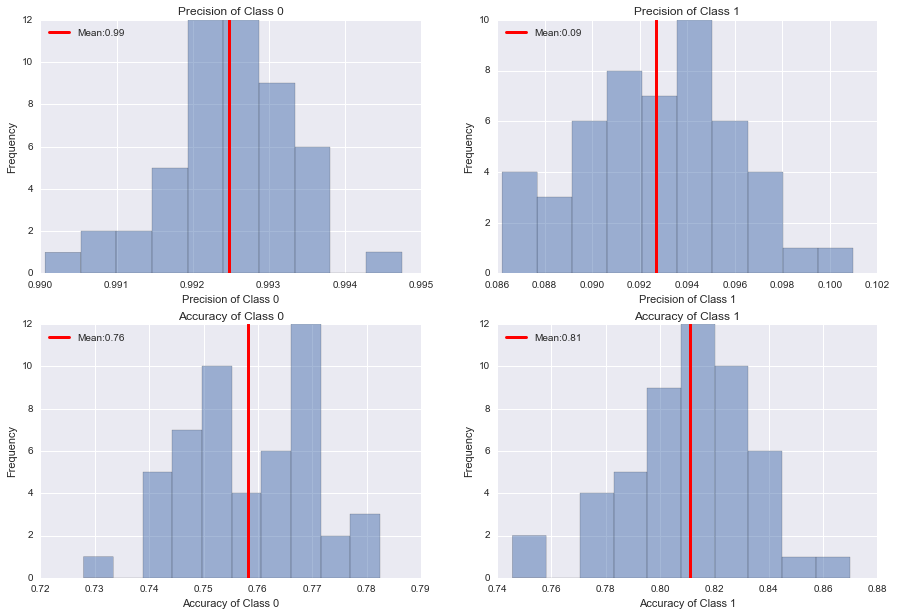

In [105]:
# Plot precision and accuracy of each class from simulations 

print ("The average accuracy of overall dataset:", np.mean(average_accuracy))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.hist(precision_0, alpha = 0.5)
mean = np.mean(precision_0)
ax1.axvline(x=mean, linewidth=3, color = 'r', label = "Mean:" + str(round(mean,2)))
ax1.set_title('Precision of Class 0')
ax1.set_xlabel('Precision of Class 0')
ax1.set_ylabel('Frequency')
ax1.legend(loc='upper left')

ax2.hist(precision_1, alpha = 0.5)
mean = np.mean(precision_1)
ax2.axvline(x=mean, linewidth=3, color = 'r', label = "Mean:" + str(round(mean,2)))
ax2.set_title('Precision of Class 1')
ax2.set_xlabel('Precision of Class 1')
ax2.set_ylabel('Frequency')
ax2.legend(loc='upper left')

ax3.hist(recall_0, alpha = 0.5)
mean = np.mean(recall_0)
ax3.axvline(x=mean, linewidth=3, color = 'r', label = "Mean:" + str(round(mean,2)))
ax3.set_title('Accuracy of Class 0')
ax3.set_xlabel('Accuracy of Class 0')
ax3.set_ylabel('Frequency')
ax3.legend(loc='upper left')

ax4.hist(recall_1, alpha = 0.5)
mean = np.mean(recall_1)
ax4.axvline(x=mean, linewidth=3, color = 'r', label = "Mean:" + str(round(mean,2)))
ax4.set_title('Accuracy of Class 1')
ax4.set_xlabel('Accuracy of Class 1')
ax4.set_ylabel('Frequency')
ax4.legend(loc='upper left')

fig.savefig("Random_forest_stats")
plt.show()

In [106]:
# Store average probability for each class from 50 simulations.
proba_0 = pd.DataFrame(proba_0)
proba_0_avg = proba_0.mean(axis=0)

proba_1 = pd.DataFrame(proba_1)
proba_1_avg = proba_1.mean(axis=0)

# Add predicted probability to dataset
df['predict_proba_class0'] = proba_0_avg
df['predict_proba_class1'] = proba_1_avg

# Predict label for each patient by comparing average predicted probability of class0 vs. class1
df['predict_label'] = pd.Series()
df['predict_label'][df['predict_proba_class0'] > df['predict_proba_class1']] = 0
df['predict_label'][df['predict_proba_class0'] < df['predict_proba_class1']] = 1

/Users/isabelle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/isabelle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [107]:
# Accuracy of whole dataset based on summary of 50 simulations
print ('Accuracy on class0:')
print (np.mean(df['predict_label'][df['hospital_death'] == 0] == 0))
print ('Accuracy on class1:')
print (np.mean(df['predict_label'][df['hospital_death'] == 1] == 1))

Accuracy on class0:
0.766013497514
Accuracy on class1:
0.899805447471


In [108]:
# Store in a .csv file
# df.to_csv("ED_with_prediction.csv", sep=',', index = False)

### Plot predicted probability of death for two classes

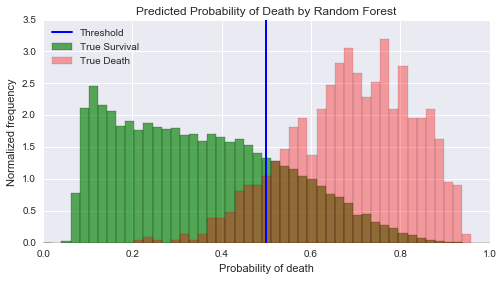

In [109]:
fig, ((ax1)) = plt.subplots(1, 1, figsize=(8, 4))

bins = np.linspace(0,1,50)
# histogram of probability of death given actually alive
ax1.hist(df['predict_proba_class1'][df['hospital_death'] == 0], alpha = 0.65, bins=bins, color = 'g', normed = True, label = 'True Survival')
# histogram of probability of death given dead
ax1.hist(df['predict_proba_class1'][df['hospital_death'] == 1], alpha = 0.35, bins=bins, color = 'r', normed = True, label = 'True Death')
ax1.axvline(x=0.5, linewidth=2, color = 'b', label = "Threshold")
ax1.set_title('Predicted Probability of Death by Random Forest')
ax1.set_xlabel('Probability of death')
ax1.set_ylabel('Normalized frequency')
ax1.legend(loc='best')

fig.savefig("Predicted probability hist")
plt.show()

Similarly to the weighted logisitc regression classifier, the optimal threshold is at the minimum of the curve traced out by the two probability distributions, and there is no clear separation of these distributions for true survival and true death.

### Analysis of Feature Importance

/Users/isabelle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


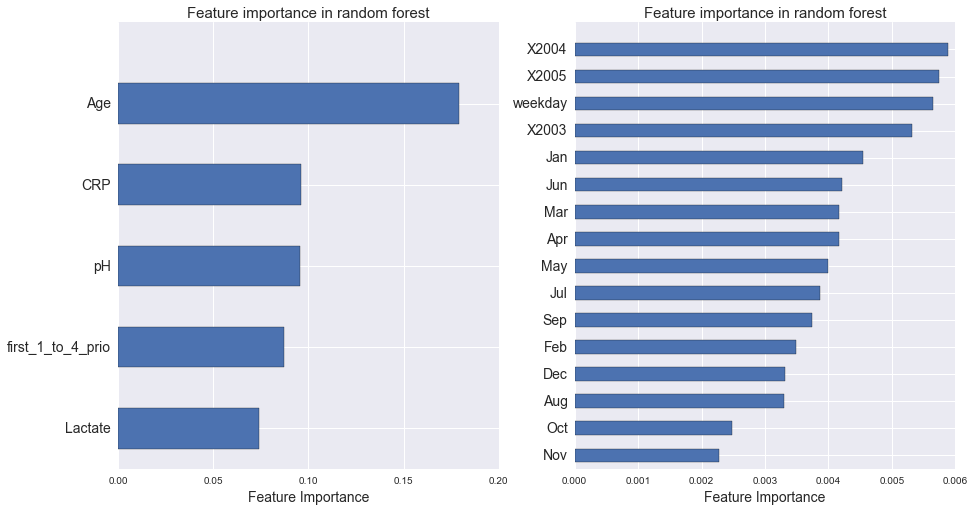

In [110]:
# Associate features with importance

features = ['weekday', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'X2003', 
            'X2004', 'X2005', 'sex', 'Age', 'EDLOS', 'first_1_to_4_prio', 'nbr_ward_instances', 'TroponinT', 
            'Lactate', 'Hemoglobin', 'CRP', 'WBC', 'pH', 'occupancy', 'available_beds', 'ED_occupancy_x', 'IPLOS']
df_feature = pd.DataFrame({'feature': features,
                           'importance': rf.feature_importances_})

# Sort feature importance from high to low
df_feature = df_feature.sort('importance')


# Plot the top 5 important features
fig = plt.figure(figsize=(15, 8))

val = df_feature['importance'][-5:] # feature_importance

N = len(val) # number of bars
ind = np.arange(N) # the y locations for the groups
width = 0.25

ax1 = fig.add_subplot(121)

ax1.barh(ind, val, align='edge',height=0.5)
ax1.set_xlim(0, 0.20)
ax1.set_ylim(-width, len(ind)+width, auto= True)

ax1.set_yticks(ind+width)
ytickNames = ax1.set_yticklabels(df_feature['feature'][-5:])
plt.setp(ytickNames, rotation=0, fontsize=14)

ax1.set_xlabel('Feature Importance', fontsize=14)
ax1.set_title('Feature importance in random forest', fontsize=15)
ax1.grid(True)


# Plot all the time features
val = df_feature['importance'][:16] # feature_importance

N = len(val) # number of bars
ind = np.arange(N) # the y locations for the groups
width = 0.25

ax2 = fig.add_subplot(122)

ax2.barh(ind, val, align='edge',height=0.5)
ax2.set_xlim(0, 0.006)
ax2.set_ylim(-width, len(ind)+width, auto= True)

ax2.set_yticks(ind+width)
ytickNames = ax2.set_yticklabels(df_feature['feature'][:16])
plt.setp(ytickNames, rotation=0, fontsize=14)

ax2.set_xlabel('Feature Importance', fontsize=14)
ax2.set_title('Feature importance in random forest', fontsize=15)
ax2.grid(True)
plt.show()




So age, pH, lactate, IPLOS(In-patient length of stay), and CRP are the five most important features in predicting hospital death. (Single simulation, number of trees = 320). In presence of lab tests and demographic features, time features are the least importance group of features in random forest. In order to look at the association between time variables and hospital death, we have to exclude the rest of the predictors. So next, we will try a random forest with only time features.

### Misclassification Analysis   
Misclassification is defined as the predicted outcome different from the observed outcome. Misclassification in each mouth is calculated, and the proportion of misclassificatioin is obtained by dividing the number of misclassification by the number of patients admitted in a given month. The proportion is then plotted across time for analysis.

In [111]:
# Create datetime object
df['ADMISSION_DATE'] = pd.to_datetime(df['ADMISSION_DATE'])

# Create month_year variable
df['month_year'] = df['ADMISSION_DATE'].apply(lambda x: x.strftime('%B-%Y'))
visits_by_monthyear = df.groupby('month_year').size() #Pandas series
visits_by_monthyear_values = df.groupby('month_year').size().values

In [112]:
misclassified_df = df[df['predict_label'] != df['hospital_death']]
misclassified_by_monthyear = misclassified_df.groupby('month_year').size() #Pandas series
misclassified_by_monthyear_values = misclassified_by_monthyear.values

In [113]:
monthyear_ordered = [
    misclassified_by_monthyear.index.values[11], #jan 2003
    misclassified_by_monthyear.index.values[8],
    misclassified_by_monthyear.index.values[20],
    misclassified_by_monthyear.index.values[0], # april 2003
    misclassified_by_monthyear.index.values[23],
    misclassified_by_monthyear.index.values[17],
    misclassified_by_monthyear.index.values[14],
    misclassified_by_monthyear.index.values[3],
    misclassified_by_monthyear.index.values[30], #september
    misclassified_by_monthyear.index.values[28],
    misclassified_by_monthyear.index.values[26],
    misclassified_by_monthyear.index.values[6], # December 2003
    misclassified_by_monthyear.index.values[12], # January 2004
    misclassified_by_monthyear.index.values[9],
    misclassified_by_monthyear.index.values[21],
    misclassified_by_monthyear.index.values[1],
    misclassified_by_monthyear.index.values[24],
    misclassified_by_monthyear.index.values[18],
    misclassified_by_monthyear.index.values[15],
    misclassified_by_monthyear.index.values[4], # august 2004
    misclassified_by_monthyear.index.values[31],
    misclassified_by_monthyear.index.values[29],
    misclassified_by_monthyear.index.values[27],
    misclassified_by_monthyear.index.values[7], # December 2004
    misclassified_by_monthyear.index.values[13], # January 2005
    misclassified_by_monthyear.index.values[10],# Febuary 2005
    misclassified_by_monthyear.index.values[22],
    misclassified_by_monthyear.index.values[2],
    misclassified_by_monthyear.index.values[25],
    misclassified_by_monthyear.index.values[19],
    misclassified_by_monthyear.index.values[16],
    misclassified_by_monthyear.index.values[5],
] 

In [114]:
proportion_misclassified_by_monthyear = np.divide(misclassified_by_monthyear_values.astype('float'), visits_by_monthyear_values.astype('float'))

In [115]:
proportion_misclassified_ordered = [
    proportion_misclassified_by_monthyear[11], #jan 2003
    proportion_misclassified_by_monthyear[8],
    proportion_misclassified_by_monthyear[20],
    proportion_misclassified_by_monthyear[0], # april 2003
    proportion_misclassified_by_monthyear[23],
    proportion_misclassified_by_monthyear[17],
    proportion_misclassified_by_monthyear[14],
    proportion_misclassified_by_monthyear[3],
    proportion_misclassified_by_monthyear[30], #september
    proportion_misclassified_by_monthyear[28],
    proportion_misclassified_by_monthyear[26],
    proportion_misclassified_by_monthyear[6], # December 2003
    proportion_misclassified_by_monthyear[12], # January 2004
    proportion_misclassified_by_monthyear[9],
    proportion_misclassified_by_monthyear[21],
    proportion_misclassified_by_monthyear[1],
    proportion_misclassified_by_monthyear[24],
    proportion_misclassified_by_monthyear[18],
    proportion_misclassified_by_monthyear[15],
    proportion_misclassified_by_monthyear[4], # august 2004
    proportion_misclassified_by_monthyear[31],
    proportion_misclassified_by_monthyear[29],
    proportion_misclassified_by_monthyear[27],
    proportion_misclassified_by_monthyear[7], # December 2004
    proportion_misclassified_by_monthyear[13], # January 2005
    proportion_misclassified_by_monthyear[10],# Febuary 2005
    proportion_misclassified_by_monthyear[22],
    proportion_misclassified_by_monthyear[2],
    proportion_misclassified_by_monthyear[25],
    proportion_misclassified_by_monthyear[19],
    proportion_misclassified_by_monthyear[16],
    proportion_misclassified_by_monthyear[5],
] 

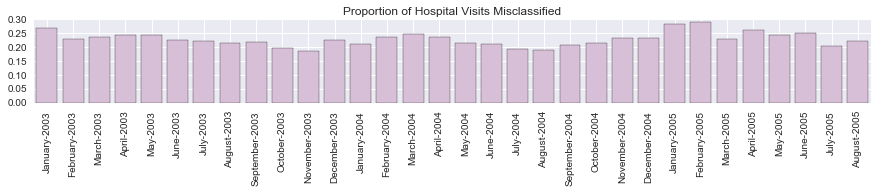

In [116]:
fig = plt.figure(figsize=(15,1.5))
plt.bar(list(range(32)), proportion_misclassified_ordered, align='center', color='thistle')
plt.xticks(list(range(32)), monthyear_ordered, rotation='vertical')
plt.xlim([-0.5, 31.5])
plt.title('Proportion of Hospital Visits Misclassified')
plt.show()
fig.savefig('misclassified_overtime_rf.png')

### Random Forest with Time Variables ONLY

In [5]:
# Load data
df = pd.read_csv("ED_with_time_indicators_2nd.csv")
df = df[['Unnamed: 0', 'ADMISSION_DATE', 'day', 'month', 'year', 'admission_datetime', 'weekday', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'X2003', 'X2004', 'X2005', 'sex', 'Age', 'EDLOS', 'first_1_to_4_prio', 'nbr_ward_instances', 'TroponinT', 'Lactate', 'Hemoglobin', 'CRP', 'WBC', 'pH', 'occupancy', 'available_beds', 'ED_occupancy_x', 'IPLOS', 'hospital_death']]
df.shape

(34812, 38)

In [118]:
# Separate predictors and outcome (admission_datetime not included)
x = df.iloc[:, 6:22].values
y = df.iloc[:, -1].values

# Standardization
x = preprocessing.scale(x)

# Split the dataset in two equal parts
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=0)

/Users/isabelle/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [119]:
#Function for computing the accuracy a given model on the entire test set, the accuracy on class 0 in the test set
#and the accuracy on class 1
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])],
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

### Model fitting using balanced dataset (undersampling survival)

In [120]:
# Create balanced train set by sampling equal controls and cases 

# Concatenate x_train and y_train
y_train = y_train.reshape(len(y_train),1)
train = np.concatenate((x_train,y_train),axis =1)

# separate cases and controls in the training set
cases = train[train[:, -1]==1]
controls = train[train[:, -1]==0]


# permute controls, and choose same number of controls as cases 
n_control = controls.shape[0]
perm = np.random.randint(low=0, high=n_control, size=n_control) # Generate a list of indices 0 to n and permute it    
controls_perm = controls[perm]
controls_subsample = controls_perm[:cases.shape[0]] 

# Form balanced training set with equal cases and controls
train = np.concatenate((controls_subsample, cases), axis = 0)
# Separate predictors and labels
x_train = train[:, :-1]
y_train = train[:, -1]

In [121]:
#Weighted logistic regression
weighted_logistic = LogReg(penalty = 'l1', C=1, class_weight='balanced')
weighted_logistic.fit(x_train, y_train)
weighted_log_scores = score(weighted_logistic, x_test, y_test)


#LDA
lda = LDA()
lda.fit(x_train, y_train)
lda_scores = score(lda, x_test, y_test)


#QDA
qda = QDA()
qda.fit(x_train, y_train)
qda_scores = score(qda, x_test, y_test)


#Decision Tree
tree = DecisionTree(class_weight = "balanced")
tree.fit(x_train, y_train)
tree_scores = score(tree, x_test, y_test)


#Random Forest
rf = RandomForest(class_weight = 'balanced')
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)


#SVM
SVM = SVC(C=100, class_weight = 'balanced')
SVM.fit(x_train, y_train)
SVM_scores = score(SVM, x_test, y_test)

In [122]:
#Score Dataframe
score_df = pd.DataFrame({'weighted logistic': weighted_log_scores,
                         'weighted lda': lda_scores,
                         'weighted qda': qda_scores,
                         'weighted tree': tree_scores,
                         'weighted rf': rf_scores,
                         'weighted SVM': SVM_scores})
score_df

,weighted SVM,weighted lda,weighted logistic,weighted qda,weighted rf,weighted tree
overall accuracy,0.480064,0.566701,0.569516,0.636734,0.479490,0.551764
accuracy on class 0,0.478650,0.570869,0.573775,0.645475,0.478176,0.555450
accuracy on class 1,0.523897,0.437500,0.437500,0.365809,0.520221,0.437500


### Random forest with time variables ONLY tuning

In [123]:
# Set the parameters by cross-validation
tuned_parameters = [{"n_estimators": [20, 40, 80, 160, 320], "max_depth": [2, 4, 8, 16, 32], 'max_features': [2, 4, 8, 16]}]

scores = ['precision', 'recall']

for score in scores:
    print "# Tuning hyper-parameters for %s" % score
    print

    rf = GridSearchCV(RandomForest(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    rf.fit(x_train, y_train)

    print "Best parameters set found on development set:"
    print
    print rf.best_params_
    print
    

    print "Detailed classification report:"
    print
    print "The model is trained on the full development set."
    print "The scores are computed on the full evaluation set."
    print 
    y_true, y_pred = y_test, rf.predict(x_test)
    print classification_report(y_true, y_pred)
    print

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'max_features': 2, 'n_estimators': 20, 'max_depth': 4}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.97      0.49      0.65     16862
          1       0.03      0.51      0.06       544

avg / total       0.94      0.49      0.63     17406


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'max_features': 16, 'n_estimators': 40, 'max_depth': 8}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.97      0.54      0.69     16862
          1       0.03      0.47      0.06       544

avg / total       0.94      0.53      0.67     17406




So the best parameter set is {'max_features': 16, 'n_estimators': 20, 'max_depth': 8}. The accuracy for class0 and class1 are 0.58 and 0.45 respectively.

### Simulation of random forest with time variables only 50 times with best parameters:

In [6]:
from sklearn.metrics import precision_recall_fscore_support
# Separate predictors and outcome (admission_datetime not included)
x = df.iloc[:, 6:22].values
y = df.iloc[:, -1].values

# Standardization
x = preprocessing.scale(x)

# Store stats for two classes separately
precision_0 = []
recall_0 = []

precision_1 = []
recall_1 = []

average_accuracy = []

# Store probability for two classes
proba_0 = []
proba_1 = []

for simulation in range(50):
    # Split the dataset in two equal parts
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
    
    # Create balanced train set by sampling equal controls and cases 
    # Concatenate x_train and y_train
    y_train = y_train.reshape(len(y_train),1)
    train = np.concatenate((x_train,y_train),axis =1)

    # separate cases and controls in the training set
    cases = train[train[:, -1]==1]
    controls = train[train[:, -1]==0]

    # permute controls, and choose same number of controls as cases 
    n_control = controls.shape[0]
    perm = np.random.randint(low=0, high=n_control, size=n_control) # Generate a list of indices 0 to n and permute it    
    controls_perm = controls[perm]
    controls_subsample = controls_perm[:cases.shape[0]] 

    # Form balanced training set with equal cases and controls
    train = np.concatenate((controls_subsample, cases), axis = 0)
    # Separate predictors and labels
    x_train = train[:, :-1]
    y_train = train[:, -1]
    
    # Fit random forest
    rf = RandomForest(n_estimators = 20, max_features = 16, max_depth = 8)
    rf.fit(x_train, y_train)
    
    # Compute stats
    y_true, y_pred = y_test, rf.predict(x_test)
    stats = precision_recall_fscore_support(y_true, y_pred)
    precision_0.append(stats[0][0])
    precision_1.append(stats[0][1])
    recall_0.append(stats[1][0])
    recall_1.append(stats[1][1])
    average_accuracy.append(rf.score(x_test, y_true))
    
    # Store probabilities
    proba = pd.DataFrame(rf.predict_proba(x))
    proba_0.append(proba[0])
    proba_1.append(proba[1])

/Users/nancy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


('The average accuracy of overall dataset:', 0.50998736068022521)


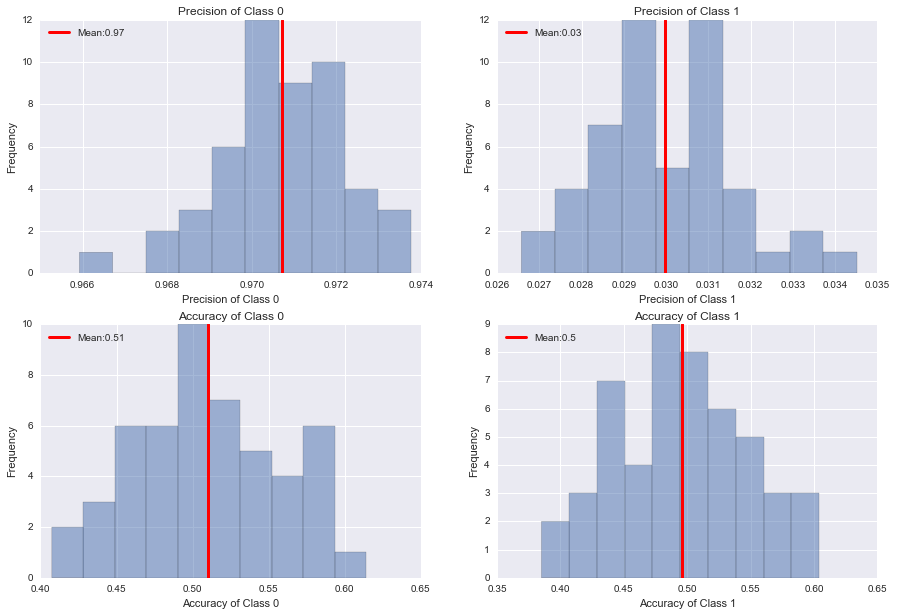

In [125]:
# Plot precision and accuracy of each class from simulations 

print ("The average accuracy of overall dataset:", np.mean(average_accuracy))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.hist(precision_0, alpha = 0.5)
mean = np.mean(precision_0)
ax1.axvline(x=mean, linewidth=3, color = 'r', label = "Mean:" + str(round(mean,2)))
ax1.set_title('Precision of Class 0')
ax1.set_xlabel('Precision of Class 0')
ax1.set_ylabel('Frequency')
ax1.legend(loc='upper left')

ax2.hist(precision_1, alpha = 0.5)
mean = np.mean(precision_1)
ax2.axvline(x=mean, linewidth=3, color = 'r', label = "Mean:" + str(round(mean,2)))
ax2.set_title('Precision of Class 1')
ax2.set_xlabel('Precision of Class 1')
ax2.set_ylabel('Frequency')
ax2.legend(loc='upper left')

ax3.hist(recall_0, alpha = 0.5)
mean = np.mean(recall_0)
ax3.axvline(x=mean, linewidth=3, color = 'r', label = "Mean:" + str(round(mean,2)))
ax3.set_title('Accuracy of Class 0')
ax3.set_xlabel('Accuracy of Class 0')
ax3.set_ylabel('Frequency')
ax3.legend(loc='upper left')

ax4.hist(recall_1, alpha = 0.5)
mean = np.mean(recall_1)
ax4.axvline(x=mean, linewidth=3, color = 'r', label = "Mean:" + str(round(mean,2)))
ax4.set_title('Accuracy of Class 1')
ax4.set_xlabel('Accuracy of Class 1')
ax4.set_ylabel('Frequency')
ax4.legend(loc='upper left')

plt.show()

In [126]:
# Store average probability for each class from 50 simulations.
proba_0 = pd.DataFrame(proba_0)
proba_0_avg = proba_0.mean(axis=0)

proba_1 = pd.DataFrame(proba_1)
proba_1_avg = proba_1.mean(axis=0)

# Add predicted probability to dataset
df['predict_proba_class0'] = proba_0_avg
df['predict_proba_class1'] = proba_1_avg

# Predict label for each patient by comparing average predicted probability of class0 vs. class1
df['predict_label'] = pd.Series()
df['predict_label'][df['predict_proba_class0'] > df['predict_proba_class1']] = 0
df['predict_label'][df['predict_proba_class0'] < df['predict_proba_class1']] = 1

/Users/isabelle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/isabelle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


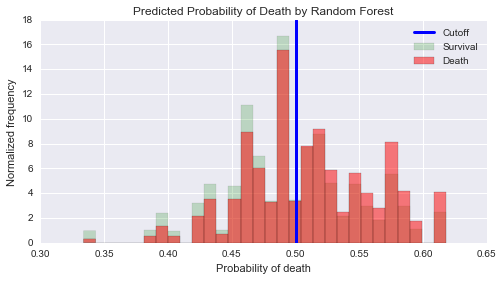

In [127]:
# plot predicted probability of death for two classes

fig, ((ax1)) = plt.subplots(1, 1, figsize=(8, 4))

# histogram of probability of death given actually alive
ax1.hist(df['predict_proba_class1'][df['hospital_death'] == 0], alpha = 0.2, bins=30, color = 'g', normed = True, label = 'Survival')
# histogram of probability of death given dead
ax1.hist(df['predict_proba_class1'][df['hospital_death'] == 1], alpha = 0.5, bins=30, color = 'r', normed = True, label = 'Death')
ax1.axvline(x=0.5, linewidth=3, color = 'b', label = "Cutoff")
ax1.set_title('Predicted Probability of Death by Random Forest')
ax1.set_xlabel('Probability of death')
ax1.set_ylabel('Normalized frequency')
ax1.legend(loc='best')
plt.show()

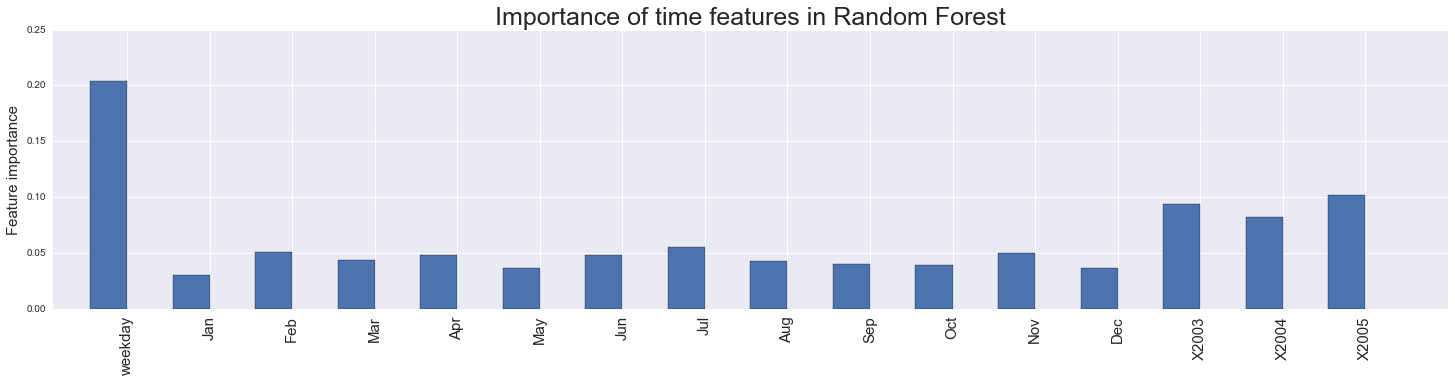

In [128]:
features = ['weekday', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'X2003', 'X2004', 'X2005']

# Plot feature importance
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(111)

N = len(features)
ind = np.arange(N) # the x locations for the groups

width = 0.45                      # the width of the bars

## the bars
ax.bar(ind, rf.feature_importances_, width)

# axes and labels
ax.set_xlim(-width, len(ind)+width)
ax.set_ylim(0, 0.25)
ax.set_ylabel('Feature importance', fontsize= 15)
ax.set_title('Importance of time features in Random Forest', fontsize = 25)
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(features)
plt.setp(xtickNames, rotation=90, fontsize=15)

#fig.savefig("Features_rf_timeonly")
plt.show()

/Users/nancy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


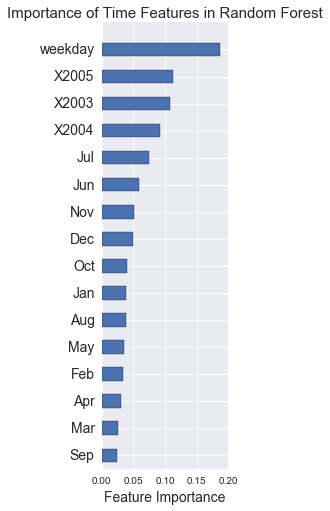

In [7]:
# Associate features with importance

features = ['weekday', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'X2003', 
            'X2004', 'X2005']
df_feature = pd.DataFrame({'feature': features,
                           'importance': rf.feature_importances_})

# Sort feature importance from high to low
df_feature = df_feature.sort('importance')


# Plot the top 5 important features
fig = plt.figure(figsize=(5, 8))

val = df_feature['importance'] # feature_importance

N = len(val) # number of bars
ind = np.arange(N) # the y locations for the groups
width = 0.25

ax = fig.add_subplot(121)

ax.barh(ind, val, align='edge',height=0.5)
ax.set_xlim(0, 0.20)
ax.set_ylim(-width, len(ind)+width, auto= True)

ax.set_yticks(ind+width)
ytickNames = ax.set_yticklabels(df_feature['feature'])
plt.setp(ytickNames, rotation=0, fontsize=14)

ax.set_xlabel('Feature Importance', fontsize=14)
ax.set_title('Importance of Time Features in Random Forest', fontsize=15)
ax.grid(True)
plt.show()

So age, lactate, CRP, pH and IPLOS are the five most importance features in predicting hospital death. (Single simulation, number of trees = 320).

## Does our random forest model really do better than just guessing?

In [130]:
from sklearn.metrics import f1_score
#### BASELINE MODEL ####
# Randomly assign 0 or 1 to each patient
# simulate the process for 50 times, calculate f1 score
# Compare f1 score of baseline model to f1 score of random forest

# Load data
df = pd.read_csv("ED_with_time_indicators_2nd.csv")
df = df[['Unnamed: 0', 'ADMISSION_DATE', 'day', 'month', 'year', 'admission_datetime', 'weekday', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'X2003', 'X2004', 'X2005', 'sex', 'Age', 'EDLOS', 'first_1_to_4_prio', 'nbr_ward_instances', 'TroponinT', 'Lactate', 'Hemoglobin', 'CRP', 'WBC', 'pH', 'occupancy', 'available_beds', 'ED_occupancy_x', 'IPLOS', 'hospital_death']]

# Separate predictors and outcome (admission_datetime not included)
x = df.iloc[:, 6:22].values
y = df.iloc[:, -1].values

# Randomly assign 0 and 1 based on the proportion of their occurence in the dataset
# simulate 101 times
accuracy_0 = []
accuracy_1 = []
f1_bs = []

for simulation in range(50):
    pred_label = np.random.binomial(1, 0.5, size = df.shape[0])
    accuracy_0.append(np.mean(pred_label[y==0]==0))
    accuracy_1.append(np.mean(pred_label[y==1]==1))
    f1_bs.append(f1_score(y, pred_label))

print "Average accuracy on Class0:", np.mean(accuracy_0)
print "Average accuracy on Class1:", np.mean(accuracy_1)
print "F1 score:", np.mean(f1_bs)

Average accuracy on Class0: 0.500142079091
Average accuracy on Class1: 0.499766536965
F1 score: 0.055757600047


In [131]:
#### RANDOM FOREST MODEL ####

# Standardization
x = preprocessing.scale(x)

# Store stats for two classes separately

recall_0 = []
recall_1 = []

average_accuracy = []
f1_rf = []

for simulation in range(50):
    # Split the dataset in two equal parts
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
    
    # Create balanced train set by sampling equal controls and cases 
    # Concatenate x_train and y_train
    y_train = y_train.reshape(len(y_train),1)
    train = np.concatenate((x_train,y_train),axis =1)

    # separate cases and controls in the training set
    cases = train[train[:, -1]==1]
    controls = train[train[:, -1]==0]

    # permute controls, and choose same number of controls as cases 
    n_control = controls.shape[0]
    perm = np.random.randint(low=0, high=n_control, size=n_control) # Generate a list of indices 0 to n and permute it    
    controls_perm = controls[perm]
    controls_subsample = controls_perm[:cases.shape[0]] 

    # Form balanced training set with equal cases and controls
    train = np.concatenate((controls_subsample, cases), axis = 0)
    # Separate predictors and labels
    x_train = train[:, :-1]
    y_train = train[:, -1]
    
    # Fit random forest
    rf = RandomForest(n_estimators = 20, max_features = 16, max_depth = 8)
    rf.fit(x_train, y_train)
    
    # Compute stats of prediction for the whole dataset
    y_true, y_pred = y, rf.predict(x)
    stats = precision_recall_fscore_support(y_true, y_pred)
    recall_0.append(stats[1][0])
    recall_1.append(stats[1][1])
    f1_rf.append(f1_score(y, y_pred))
    average_accuracy.append(rf.score(x, y_true))

print "Average accuracy on Class0:", np.mean(recall_0)
print "Average accuracy on Class1:", np.mean(recall_1)
print "F1 score:", np.mean(f1_rf)

/Users/isabelle/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Average accuracy on Class0: 0.493840871418
Average accuracy on Class1: 0.560311284047
F1 score: 0.0616417535503


The accuracy on both classes given by the baseline model and random forest are 50%. So do we really have any evidence that the random forest model using time variables are better at predicting hospital death? Let's do a two sample t-test in comparing the f1 scores.

In [132]:
mean_bs = np.mean(f1_bs)
std_bs = np.std(f1_bs)
mean_rf = np.mean(f1_rf)
std_rf = np.std(f1_rf)
print "The mean and standard deviation of baseline model:", mean_bs, std_bs
print "The mean and standard deviation of random forest time ONLY model:", mean_rf, std_rf

from scipy import stats
stats.ttest_ind(f1_bs, f1_rf)

The mean and standard deviation of baseline model: 0.055757600047 0.001709722609
The mean and standard deviation of random forest time ONLY model: 0.0616417535503 0.00162755714939


Ttest_indResult(statistic=-17.449091879841319, pvalue=7.9894946914001296e-32)

Based on the t test, the difference between two f1 scores are highly significantly different (p<0.001). Random forest increases the f1 score by 10% compared to baseline model. 

# <font color = 'blue'><center> Part IV. Future directions </center></font>
Despite the fact that people in the US as well as overseas increasingly rely on unscheduled healthcare services [6-8], the availability of such has been reported to decrease, with discontinuing of Emergency Department services cited as an important driver [9-10]. The rate by which this happens is not likely to be constant across geographical areas, potentially aggravating inequalities that are already prevalent in a multitude of countries. 

The increasing availability of methods for predicting binary outcomes in high dimensional data, along with abundant data substrates, calls for future initiatives aiming at monitoring healthcare quality in real-time, to provide patients with up to date benchmarks of performance across providers and facilities.


Computationally, an interesting future direction would be to test anomalies online using more sensitive anomaly detection algorithms.
Model performance with and without binary time covariates did not differ significantly as seen from our misclassification analysis for the weighted logistic regression (without time variables) and random forest (with time variables), which suggests that the effect of entry time on hospital death, if there is any, is very subtle and was not captured by our models. In order to detect the subtle impact of entry time on patient death in the future, we should explore other time series anomaly detection algorithms, hopefully those more sensitive than the martingales we tried that can capture small change in the proportion of death per day in our dataset.
Another interesting analysis would be to match dead patients to survived patients based on similar demographic and biological features, and only compare the time entry of the dead patient to the alive patients to decide whether there the death is abnormal due to time of entry.

## References:
1 - Blom M, Landin-Olsson M, Lindsten M, Jonsson F, Ivarsson K. Patients presenting at the emergency department with acute abdominal pain are less likely to be admitted to inpatient wards at times of access block: a registry study. Scand J Trauma Resusc Emerg Med. 2015;23:78.


2 - Guttmann A, Schull MJ, Vermeulen MJ, Stukel TA. Association between waiting times and short term mortality and hospital admission after departure from emergency department: population based cohort study from Ontario, Canada. British Medical Journal. 2011;342:d2983.


3 - Sun BC, Hsia RY, Weiss RE, Zingmond D, Liang LJ, Han W, et al. Effect of emergency department crowding on outcomes of admitted patients. Annals of Emergency Medicine. 2013;61(6):605-11.


4 - Cha WCS, S D; Cho, J S; Song, K J; Singer, A J; Kwak, Y H. The association between crowding and mortality in admitted pediatric patients from mixed adult pediatric emergency departments in Korea. Pediatric Emergency Care. 2011;27(12):1136-41.


5 - Sprivulis PC, Da Silva JA, Jacobs IG, Frazer AR, Jelinek GA. The association between hospital overcrowding and mortality among patients admitted via Western Australian emergency departments. The Medical journal of Australia. 2006;184(5):208-12.
